## 1. Introduction and setup
This section will include the necessary imports and initial setup.

In [23]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# 2. Data Import and Preprocessing
Here let's import our data and preprocess it for analysis.
Let's first write down which systems are of interests: 
- HCl --- NH3     : 1.22 
- HCl --- Pyridine: 1.27
- HBr --- NH3     : 1.28 
- HI  --- NH3     : 1.32 

In the next cell we define a function to extract the SAPT(DFT) energy components from 1 of our calculations.

In [24]:
def extract_data_from_file(file_path):
    data = {
        'Electrostatics': None,
        'Exchange': None,
        'Induction': None,
        'SAPT(DFT) Exch-Ind(S^Inf)': None,
        'SAPT(DFT) Exch-Ind(S^2)': None,
        'Delta HF': None,
        'SAPT0 Exch-Ind(S^Inf)': None,
        'SAPT0 Exch-Ind(S^2)': None,
        'Dispersion': None,
        'Total SAPT(DFT)': None,
        'Distance': None
    }
    with open(file_path, 'r') as file:
        lines = file.readlines()
        final_table_started = False
        dhf_segment = False
        int_segment = False                
        for line in lines:
            if 'SAPT(DFT): delta HF Segment' in line:
                dhf_segment = True
            if 'SAPT(DFT): Intermolecular Interaction Segment' in line:
                dhf_segment = False
                int_segment = True
            if 'SAPT(DFT) Results' in line:
                int_segment = False
                final_table_started = True
            if not final_table_started and not dhf_segment and not int_segment:
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            if dhf_segment:
                if 'Exch-Ind20,r' in line and not '(S^inf)' in line and '[kcal/mol]' in line:
                    data['SAPT0 Exch-Ind(S^2)'] = float(parts[3])
                if 'Exch-Ind20,r (S^inf)' in line and not '(A<-B)' in line and not '(A->B)' in line:
                    data['SAPT0 Exch-Ind(S^Inf)'] = 0.62751*float(parts[2])
            if int_segment:
                if 'Exch-Ind20,r (S^inf)' in line and not '(A<-B)' in line and not '(A->B)' in line:
                    data['SAPT(DFT) Exch-Ind(S^Inf)'] = 0.62751*float(parts[2])
            if final_table_started:
                if 'Electrostatics' in line and '[kcal/mol]' in line:
                    data['Electrostatics'] = float(parts[3])
                elif 'Exchange' in line and '[kcal/mol]' in line:
                    data['Exchange'] = float(parts[3])
                elif 'Induction' in line and '[kcal/mol]' in line and not '(A<-B)' in line and not '(A->B)' in line:
                    data['Induction'] = float(parts[3])
                elif 'Exch-Ind2,r' in line and '[kcal/mol]' in line:
                    data['SAPT(DFT) Exch-Ind(S^2)'] = float(parts[3])
                elif 'delta HF,r (2)' in line and '[kcal/mol]' in line:
                    data['Delta HF'] = float(parts[5])
                elif 'Dispersion' in line and '[kcal/mol]' in line:
                    data['Dispersion'] = float(parts[3])
                elif 'Total SAPT(DFT)' in line and '[kcal/mol]' in line:
                    data['Total SAPT(DFT)'] = float(parts[4])
    # Extract distance from file name
    distance_match = re.search(r'_(\d+)_', file_path)
    if distance_match:
        data['Distance'] = int(distance_match.group(1))
    return data


In [25]:
def extract_dhf_from_file(file_path):
    dhf_data = {
        'Electrostatics': None,
        'Exchange': None,
        'Induction': None,
        'SAPT HF': None,
        'Total HF': None,
        'Delta HF': None,
        'Distance': None
    }
    with open(file_path, 'r') as file:
        lines = file.readlines()
        dhf_table_started = False
        for line in lines:
            if 'Partial SAPT(HF) Results, to compute Delta HF (dHF)' in line:
                dhf_table_started = True
            elif 'Partial SAPT(HF) Results, alternate SAPT0-like display' in line:
                dhf_table_started = False
            if not dhf_table_started:
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            if 'Electrostatics' in line and '[kcal/mol]' in line:
                dhf_data['Electrostatics'] = float(parts[3])
            elif 'Exchange' in line and '[kcal/mol]' in line:
                dhf_data['Exchange'] = float(parts[3])
            elif 'Induction' in line and '[kcal/mol]' in line and not '(A<-B)' in line and not '(A->B)' in line:
                dhf_data['Induction'] = float(parts[5])
            elif 'Subtotal' in line and '[kcal/mol]' in line:
                dhf_data['SAPT HF'] = float(parts[4])
            elif 'Total HF' in line and '[kcal/mol]' in line:
                dhf_data['Total HF'] = float(parts[4])
            elif 'Delta HF' in line and '[kcal/mol]' in line:
                dhf_data['Delta HF'] = float(parts[4])
    # Extract distance from file name
    distance_match = re.search(r'_(\d+)_', file_path)
    if distance_match:
        dhf_data['Distance'] = int(distance_match.group(1))
    return dhf_data


Subsequently we define a function to extract the same SAPT(DFT) components from the original Boese dimers calculations

In [26]:
def load_boese_dimers(file_path):
    boese_dimers = pd.read_csv(file_path, sep='\s+', comment='#', skiprows=4, names=['System', 'Electrostatics', 'Exchange', 'Induction', 'Delta HF', 'Dispersion', 'Total SAPT(DFT)'])
    boese_dimers['Distance'] = boese_dimers['System'].apply(lambda x: int(x.split('_')[1]) if '_' in x else None)
    boese_dimers = boese_dimers.dropna(subset=['Distance'])
    return boese_dimers

Next we define a function that collects the benchmark datas

In [27]:
def load_benchmark(file_path):
    benchmark = pd.read_csv(file_path, sep='\s+', comment='#', skiprows=4, names=['System', 'Total CCSD(T)/CBS'])
    benchmark['Distance'] = benchmark['System'].apply(lambda x: int(x.split('_')[1]) if '_' in x else None)
    benchmark = benchmark.dropna(subset=['Distance'])
    return benchmark

Next we define a function to collect our datas by system in a Pandas Data Frame

In [28]:
def collect_data(directory, patterns):
    all_data = []
    for pattern in patterns:
        for file_name in os.listdir(directory):
            if re.match(pattern, file_name):
                file_path = os.path.join(directory, file_name)
                data = extract_data_from_file(file_path)
                all_data.append(data)
    return pd.DataFrame(all_data)

In [29]:
def collect_dhf_data(directory, patterns):
    all_dhf_data = []
    for pattern in patterns:
        for file_name in os.listdir(directory):
            if re.match(pattern, file_name):
                file_path = os.path.join(directory, file_name)
                dhf_data = extract_dhf_from_file(file_path)
                all_dhf_data.append(dhf_data)
    return pd.DataFrame(all_dhf_data)

In [30]:
def save_my_dimers(my_dimers, system):
    file_name = f'/home/evanich/boese_dimers_calc/my_dimers_{system}.csv'
    my_dimers.to_csv(file_name, index=False)
    print(f"My dimers saved to {file_name}")

In [31]:
def save_my_dimers2(my_dimers, system):
    file_name = f'/home/evanich/boese_dimers_calc/aug_cc_pvqz_calc/my_dimers_au_cc_pvqz_{system}.csv'
    my_dimers.to_csv(file_name, index=False)
    print(f"My dimers saved to {file_name}")

In [32]:
def save_filtered_boese_dimers(boese_dimers_filtered, system):
    file_name = f'/home/evanich/boese_dimers_calc/boese_dimers_filtered_{system}.csv'
    boese_dimers_filtered.to_csv(file_name, index=False)
    print(f"Filtered Boese dimers saved to {file_name}")

In [33]:
def save_benchmark(benchmark, system):
    file_name = f'/home/evanich/boese_dimers_calc/benchmark_{system}.csv'
    benchmark.to_csv(file_name, index=False)
    print(f"Benchmark saved to {file_name}")

In [34]:
def save_dhf_my_dimers(my_dimers_dhf, system):
    file_name_dhf = f'dhf_my_dimers_{system}.csv'
    my_dimers_dhf.to_csv(file_name_dhf, index=False)
    print(f"DHF components from My dimers saved to {file_name_dhf}")

In [35]:
def save_dhf_my_dimers2(my_dimers_dhf, system):
    file_name_dhf = f'/home/evanich/boese_dimers_calc/aug_cc_pvqz_calc/dhf_my_dimers_aug_cc_pvqz_{system}.csv'
    my_dimers_dhf.to_csv(file_name_dhf, index=False)
    print(f"DHF components from My dimers saved to {file_name_dhf}")

In [36]:
#def plot_boese_dimers_from_file(file_path, system_name):
#    boese_dimers_filtered = pd.read_csv(file_path)
#    variables = ['Electrostatics', 'Exchange', 'Induction', 'Delta HF', 'Dispersion', 'Total SAPT(DFT)']
#    for variable in variables:
#        plt.figure()
#        plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label='Boese Dimers')
#        plt.title(f'{variable} vs Distance for {system_name}')
#        plt.xlabel('Distance (a.u.)')
#        plt.ylabel(f'{variable} (kcal/mol)')
#        plt.legend()
#        plt.grid(True)
#        plt.tight_layout()  # Adjust layout to prevent overlapping labels
#        plt.show()

In [37]:
#def plot_boese_dimers(boese_dimers_filtered, system_name):
#    variables = ['Electrostatics', 'Exchange', 'Induction', 'Delta HF', 'Dispersion', 'Total SAPT(DFT)']
#    for variable in variables:
#        plt.figure()
#        plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label='Boese Dimers')
#        plt.title(f'{variable} vs Distance for {system_name}')
#        plt.xlabel('Distance (a.u.)')
#        plt.ylabel(f'{variable} (kcal/mol)')
#        plt.legend()
#        plt.grid(True)
#        plt.tight_layout()  # Adjust layout to prevent overlapping labels
#        plt.show()

# 3. Plotting the datas
Finally we define a function to plot our datas together with the original Boese dimers calculations in order to confront them

In [38]:
#def plot_data(my_dimers, boese_dimers, system, system_name):
#    variables = ['Electrostatics', 'Exchange', 'Induction', 'Delta HF', 'Dispersion', 'Total SAPT(DFT)']
#    boese_dimers_filtered = boese_dimers[boese_dimers['System'].str.startswith(system)]
#    print(f"Filtered Boese dimers for system {system}:")
#    print(boese_dimers_filtered)
#    for variable in variables:
#        plt.figure()
#        plt.plot(my_dimers['Distance'], my_dimers[variable], marker='o', label='My Dimers')
#        plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label='Boese Dimers')
#        plt.title(f'{variable} vs Distance for {system_name}')
#        plt.xlabel('Distance (a.u.)')
#        plt.ylabel(f'{variable} (kcal/mol)')
#        plt.legend()
#        plt.grid(True)
#        plt.tight_layout()
#        plt.show()


def plot_data(system, system_name):
    boese_file_path = f'/home/evanich/boese_dimers_calc/boese_dimers_filtered_{system}.csv'
    my_file_path = f'/home/evanich/boese_dimers_calc/my_dimers_{system}.csv'
    benchmark_path = f'/home/evanich/boese_dimers_calc/benchmark_{system}.csv'
    boese_dimers_filtered = pd.read_csv(boese_file_path)
    my_dimers = pd.read_csv(my_file_path)
    benchmark = pd.read_csv(benchmark_path)
    # Subtract Delta HF from Induction in my_dimers
    my_dimers['Induction'] = my_dimers['Induction'] - my_dimers['Delta HF']
    # Create a new dataset were we have subtracted Delta hF from he total also from both boese_dimers and my_dimers
    my_dimers['Total SAPT(DFT) no DHF'] = my_dimers['Total SAPT(DFT)'] - my_dimers['Delta HF']
    boese_dimers_filtered['Total SAPT(DFT) no DHF'] = boese_dimers_filtered['Total SAPT(DFT)'] - boese_dimers_filtered['Delta HF']
    # Create a new dataset were we have replaced S^2 with S^inf in Delta HF and Induction
    my_dimers['Induction (S^Inf)'] = my_dimers['Induction'] - my_dimers['SAPT(DFT) Exch-Ind(S^2)'] + my_dimers['SAPT(DFT) Exch-Ind(S^Inf)']
    my_dimers['Delta HF (S^Inf)'] = my_dimers['Delta HF'] + my_dimers['SAPT0 Exch-Ind(S^2)'] - my_dimers['SAPT0 Exch-Ind(S^Inf)']
    # Now create the new total
    my_dimers['Total SAPT(DFT) (S^Inf)'] = my_dimers['Total SAPT(DFT) no DHF'] - my_dimers['Induction'] + my_dimers['Induction (S^Inf)'] + my_dimers['Delta HF (S^Inf)']
    variables = ['Electrostatics', 'Exchange', 'Induction', 'Delta HF', 'Dispersion', 'Total SAPT(DFT)', 'Total SAPT(DFT) no DHF', 'Induction (S^Inf)', 'Delta HF (S^Inf)', 'Total SAPT(DFT) (S^Inf)']
    for variable in variables:
        plt.figure()
        plt.plot(my_dimers['Distance'], my_dimers[variable], marker='o', label='SAPT(DFT) Psi4')
        if variable in ['Induction (S^Inf)', 'Delta HF (S^Inf)', 'Total SAPT(DFT) (S^Inf)']:
            corresponding_variable = variable.split(' (S^Inf)')[0]
            plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[corresponding_variable], marker='x', label='Boese Dimers')
        else:
            plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label='Boese Dimers')      
        if variable in ['Total SAPT(DFT)', 'Total SAPT(DFT) no DHF']:
                plt.plot(benchmark['Distance'], benchmark['Total CCSD(T)/CBS'], marker='o', label='Benchmark')
        plt.title(f'{variable} vs Distance for {system_name}')
        plt.xlabel('Distance (a.u.)')
        plt.ylabel(f'{variable} (kcal/mol)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent overlapping labels
        plt.show()
    additional_variables = ['Induction', 'Delta HF', 'Total SAPT(DFT)']
    for variable in additional_variables:
        plt.figure()
        plt.plot(my_dimers['Distance'], my_dimers[variable], marker='o', label=f'{variable} SAPT(DFT) Psi4')
        plt.plot(my_dimers['Distance'], my_dimers[f'{variable} (S^Inf)'], marker='o', label=f'{variable} (S^Inf) SAPT(DFT) Psi4')
        plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label=f'{variable} Boese Dimers')
        plt.title(f'{variable} vs Distance for {system_name}')
        plt.xlabel('Distance (a.u.)')
        plt.ylabel(f'{variable} (kcal/mol)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent overlapping labels
        plt.show()

In [39]:
def plot_data_wcomponents(system, system_name):
    boese_file_path = f'boese_dimers_filtered_{system}.csv'
    my_file_path = f'my_dimers_{system}.csv'
    my_file_path_dhf = f'dhf_my_dimers_{system}.csv'
    boese_dimers_filtered = pd.read_csv(boese_file_path)
    my_dimers = pd.read_csv(my_file_path)
    my_dimers_dhf = pd.read_csv(my_file_path_dhf)
    # Subtract Delta HF from Induction in my_dimers
    my_dimers['Induction'] = my_dimers['Induction'] - my_dimers['Delta HF']
    variables = ['Electrostatics', 'Exchange', 'Induction', 'Delta HF',]
    for variable in variables:
        plt.figure()
        plt.plot(my_dimers['Distance'], my_dimers[variable], marker='o', label='SAPT(DFT) Psi4')
        plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf[variable], marker='o', label='SAPT0 component Psi4')
        plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered[variable], marker='x', label='Boese Dimers')
        plt.title(f'{variable} vs Distance for {system_name}')
        plt.xlabel('Distance (a.u.)')
        plt.ylabel(f'{variable} (kcal/mol)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent overlapping labels
        plt.show()

In [40]:
def plot_dhf_data(system, system_name):
    boese_file_path = f'boese_dimers_filtered_{system}.csv'
    my_file_path_dhf = f'dhf_my_dimers_{system}.csv'
    boese_dimers_filtered = pd.read_csv(boese_file_path)
    my_dimers_dhf = pd.read_csv(my_file_path_dhf)
    #variables = ['Electrostatics', 'Exchange', 'Induction', 'SAPT HF', 'Total HF', 'Delta HF']
    plt.figure()
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['Electrostatics'], marker='o', label='Electrostatics')
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['Exchange'], marker='o', label='Exchange')
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['Induction'], marker='o', label='Induction')
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['SAPT HF'], marker='o', label='Subtotal HF')
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['Total HF'], marker='o', label='Total HF')
    plt.plot(my_dimers_dhf['Distance'], my_dimers_dhf['Delta HF'], marker='o', label='Delta HF')
    plt.plot(boese_dimers_filtered['Distance'], boese_dimers_filtered['Delta HF'], marker='x', label='Boese Dimers Delta HF')
    plt.title(f'Delta HF components vs Distance for {system_name}')
    plt.xlabel('Distance (a.u.)')
    plt.ylabel(f'Component (kcal/mol)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()

## 4. Running the code
Here we run the Python code and the functions previously defined.

Filtered Boese dimers saved to /home/evanich/boese_dimers_calc/boese_dimers_filtered_1.22.csv
My dimers saved to /home/evanich/boese_dimers_calc/my_dimers_1.22.csv
DHF components from My dimers saved to dhf_my_dimers_1.22.csv
Benchmark saved to /home/evanich/boese_dimers_calc/benchmark_1.22.csv
SAPT0 Exch-Ind(S^2) = 0    27.565118
1    20.835251
2    15.667696
3    11.733865
4     8.760013
5     6.524326
6     4.850833
7     1.982568
8     0.444899
9     0.022683
Name: SAPT0 Exch-Ind(S^2), dtype: float64
SAPT0 Exch-Ind(S^Inf) = 0    33.845879
1    24.583029
2    17.892081
3    13.048113
4     9.533540
5     6.978130
6     5.116340
7     2.035091
8     0.448336
9     0.022697
Name: SAPT0 Exch-Ind(S^Inf), dtype: float64
Delta HF (S^2) = 0   -16.635434
1   -13.800432
2   -11.166854
3    -8.879276
4    -6.971692
5    -5.423238
6    -4.189565
7    -1.881306
8    -0.476383
9    -0.030805
Name: Delta HF, dtype: float64
Delta HF (S^Inf) = 0   -22.916195
1   -17.548210
2   -13.391239
3   -10.19

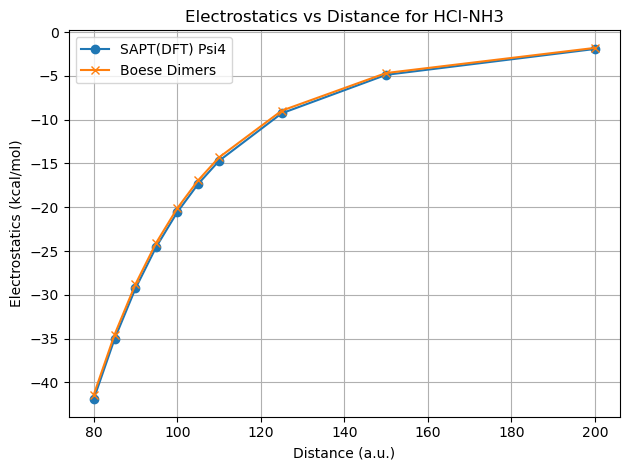

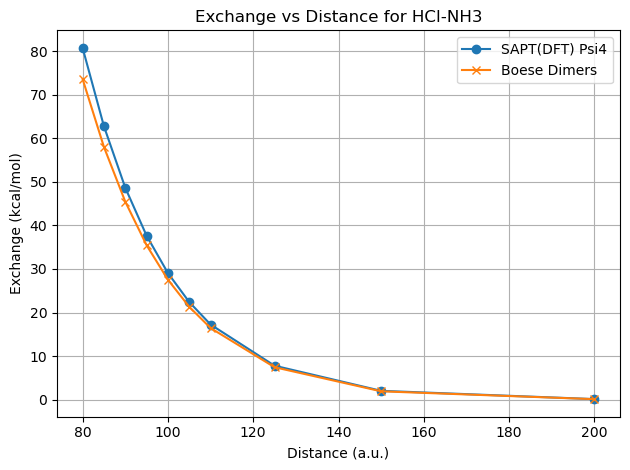

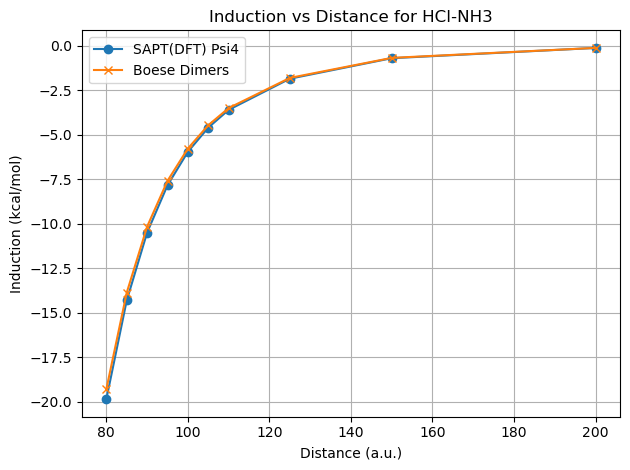

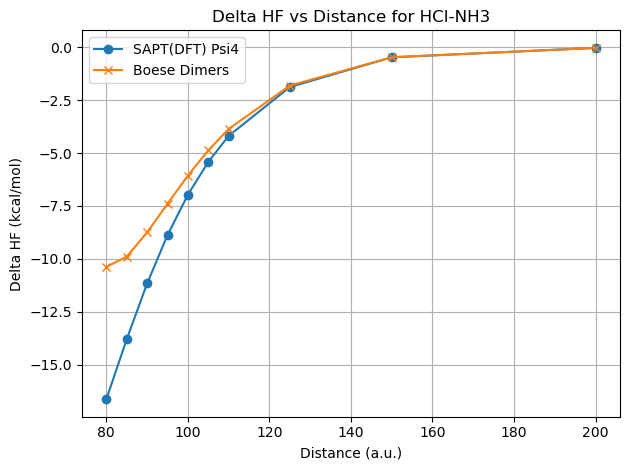

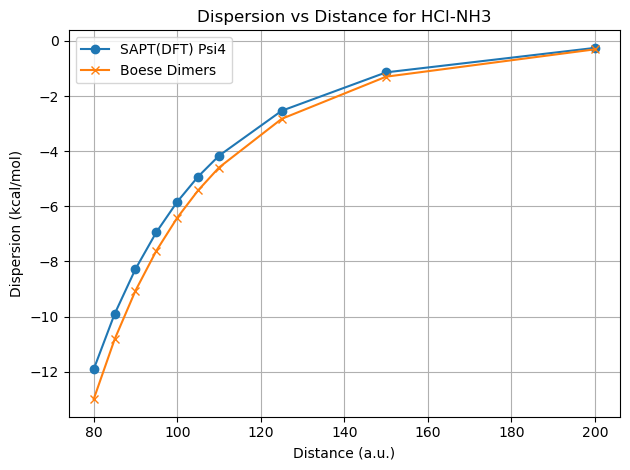

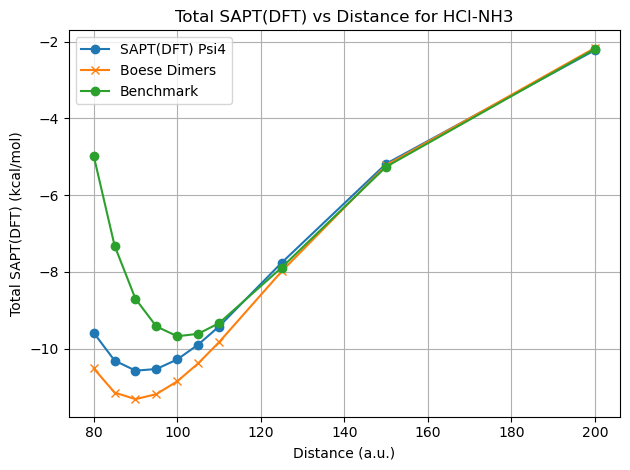

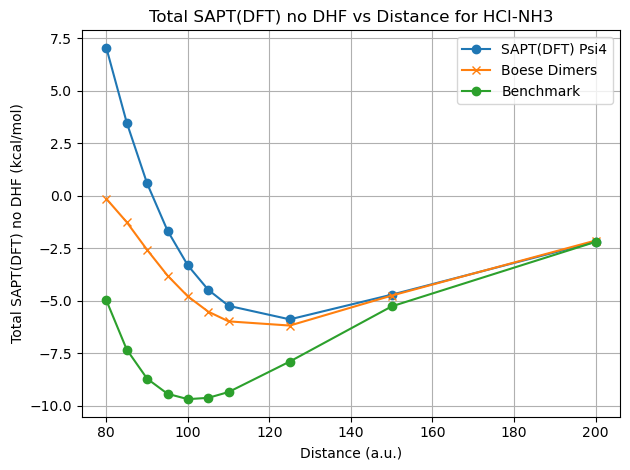

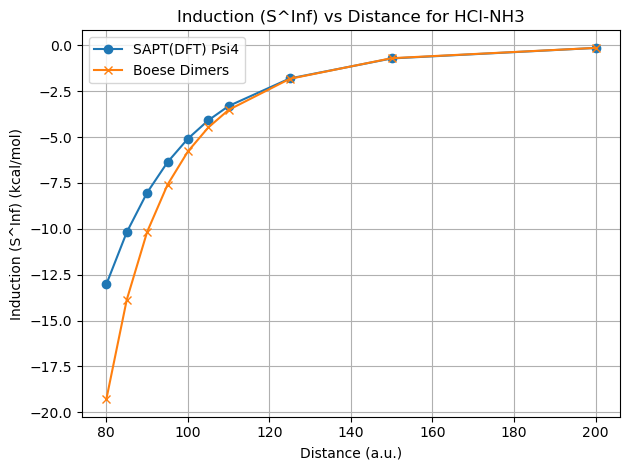

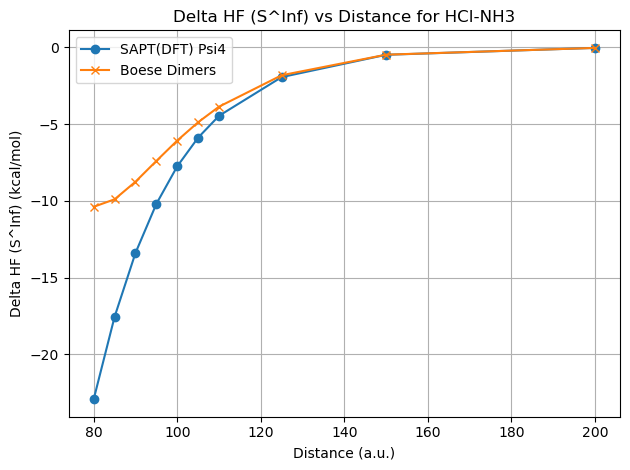

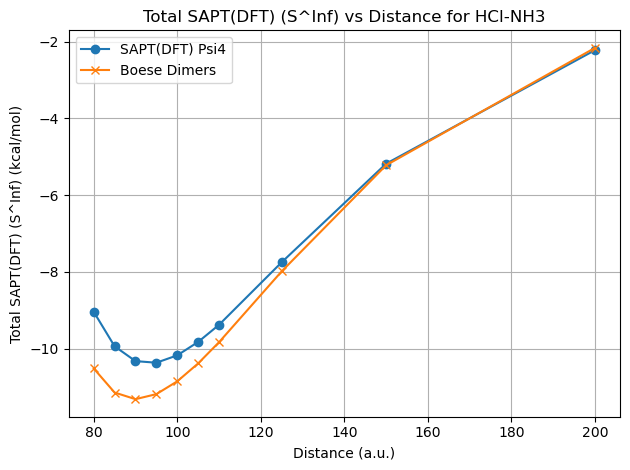

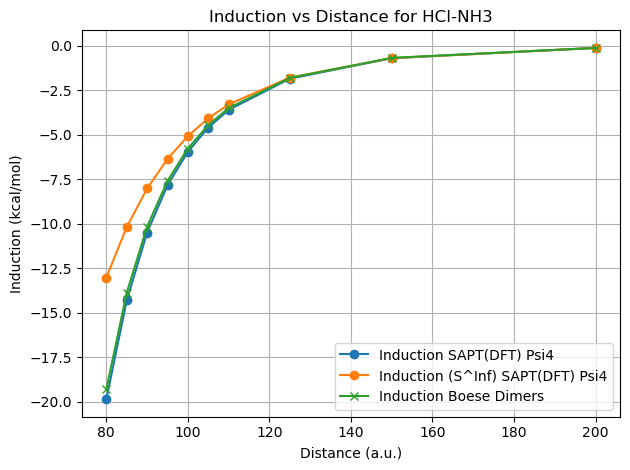

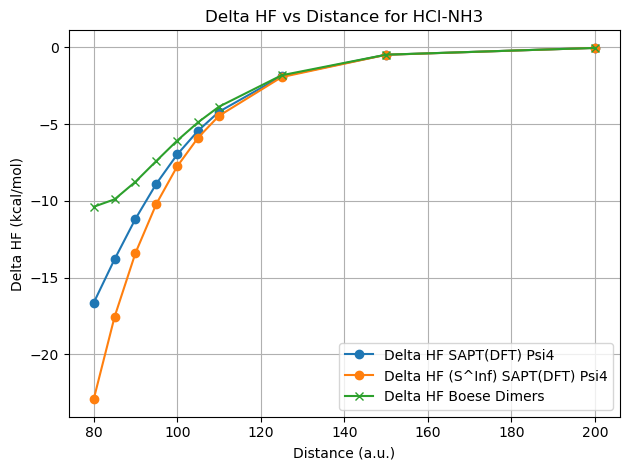

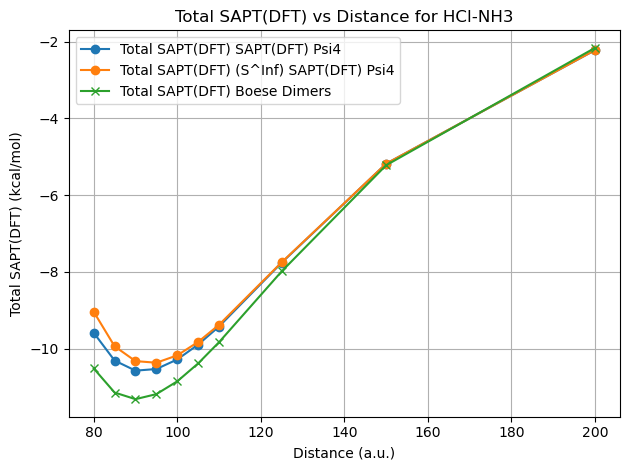

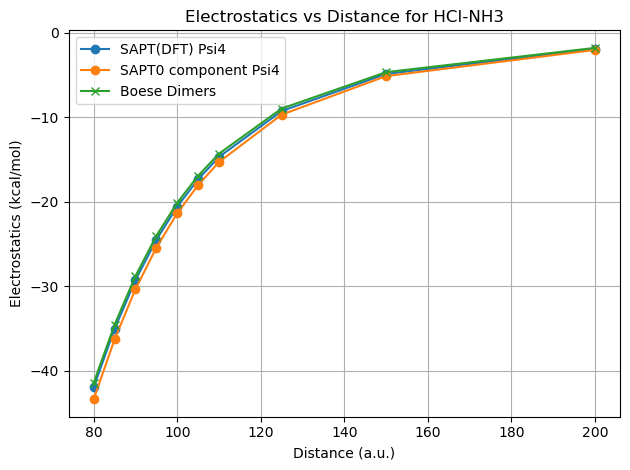

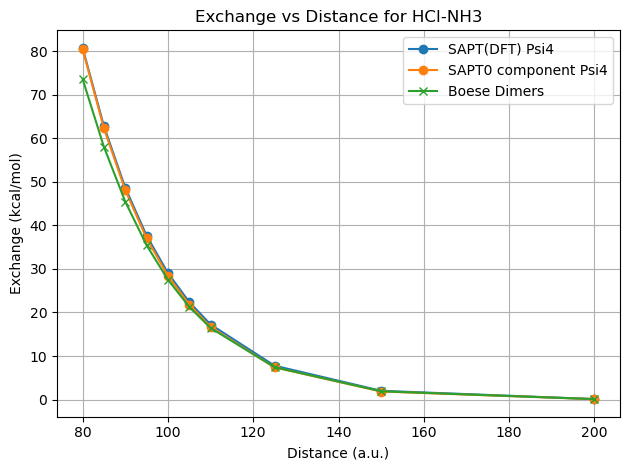

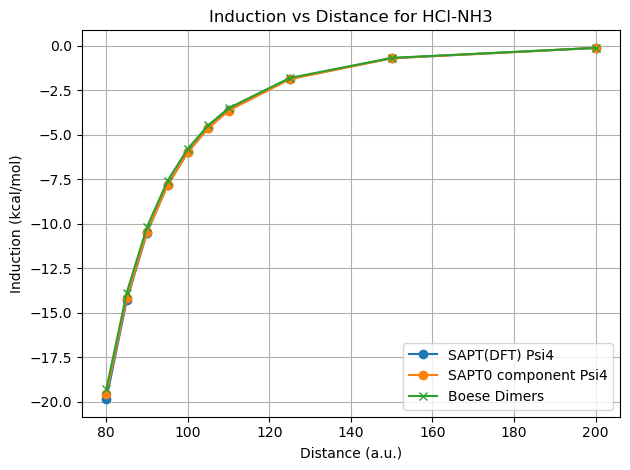

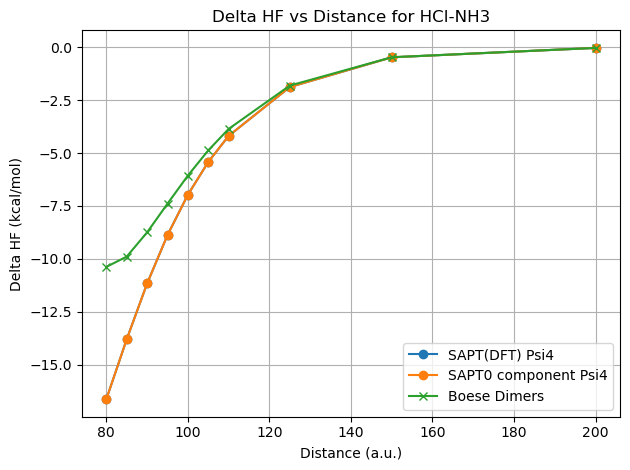

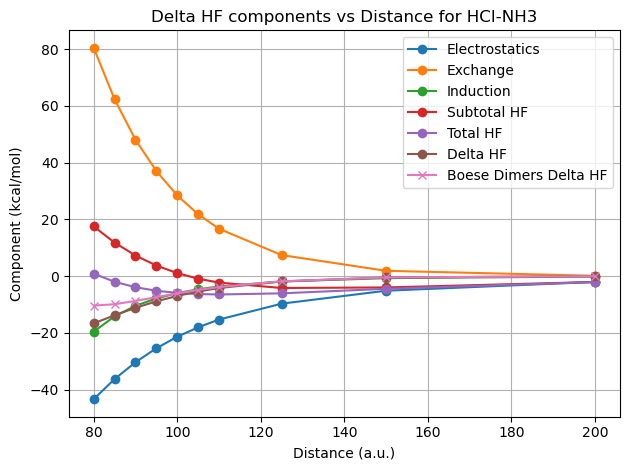

Filtered Boese dimers saved to /home/evanich/boese_dimers_calc/boese_dimers_filtered_1.27.csv
My dimers saved to /home/evanich/boese_dimers_calc/my_dimers_1.27.csv
DHF components from My dimers saved to dhf_my_dimers_1.27.csv
Benchmark saved to /home/evanich/boese_dimers_calc/benchmark_1.27.csv
SAPT0 Exch-Ind(S^2) = 0    34.972481
1    26.908255
2    20.576141
3    15.652423
4    11.855969
5     8.949272
6     6.737283
7     2.846011
8     0.670684
9     0.038437
Name: SAPT0 Exch-Ind(S^2), dtype: float64
SAPT0 Exch-Ind(S^Inf) = 0    44.989435
1    33.063924
2    24.335327
3    17.935386
4    13.235705
5     9.779598
6     7.235211
7     2.951634
8     0.678397
9     0.038477
Name: SAPT0 Exch-Ind(S^Inf), dtype: float64
Delta HF (S^2) = 0   -20.919836
1   -18.026018
2   -15.048868
3   -12.291555
4    -9.883290
5    -7.855862
6    -6.191357
7    -2.934302
8    -0.806788
9    -0.062494
Name: Delta HF, dtype: float64
Delta HF (S^Inf) = 0   -30.936790
1   -24.181687
2   -18.808054
3   -14.57

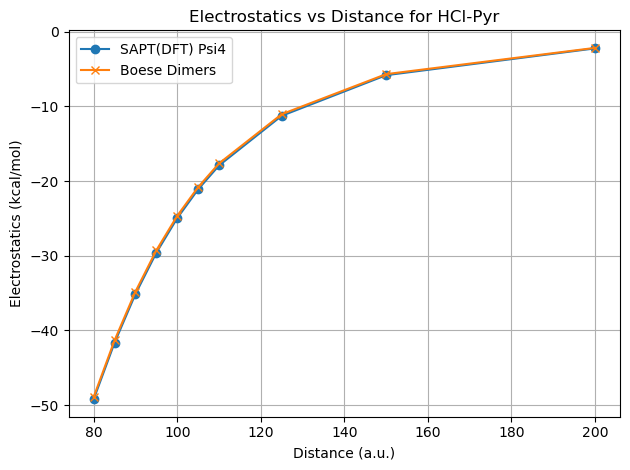

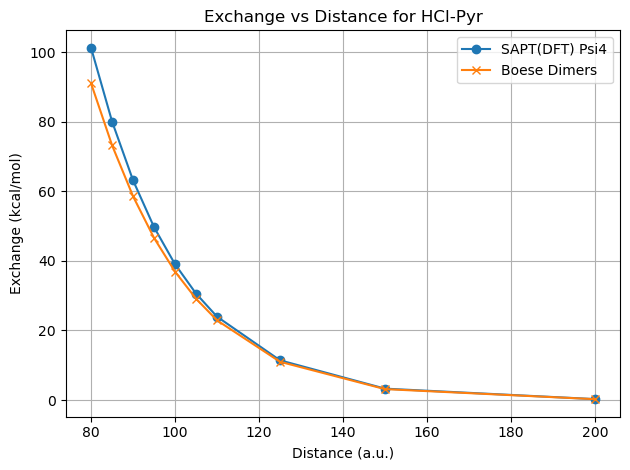

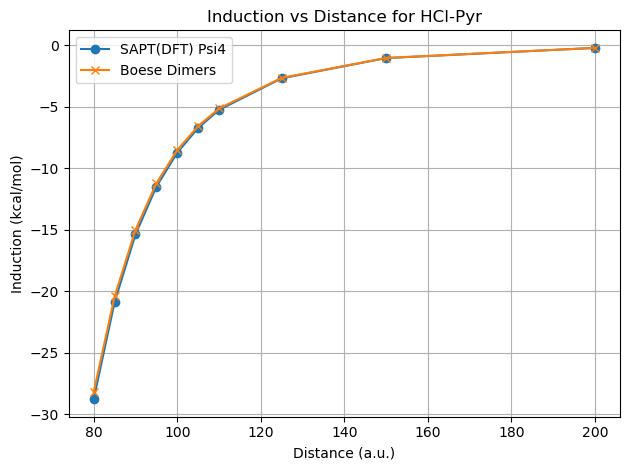

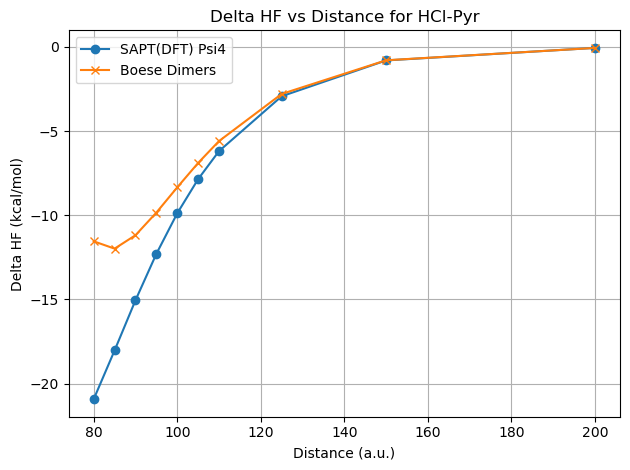

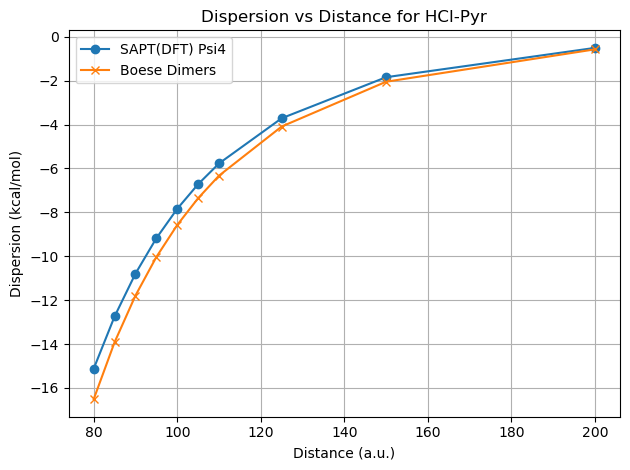

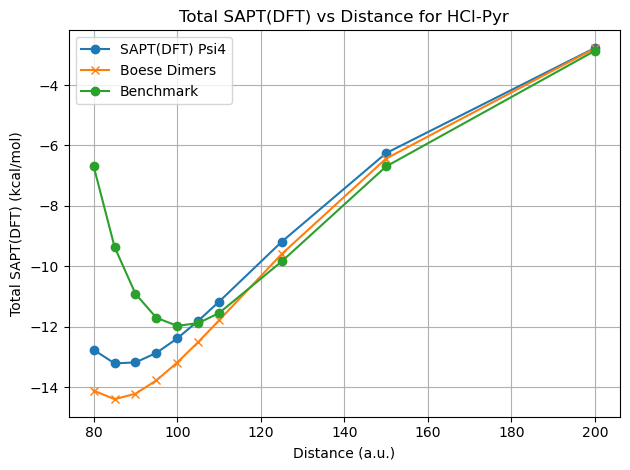

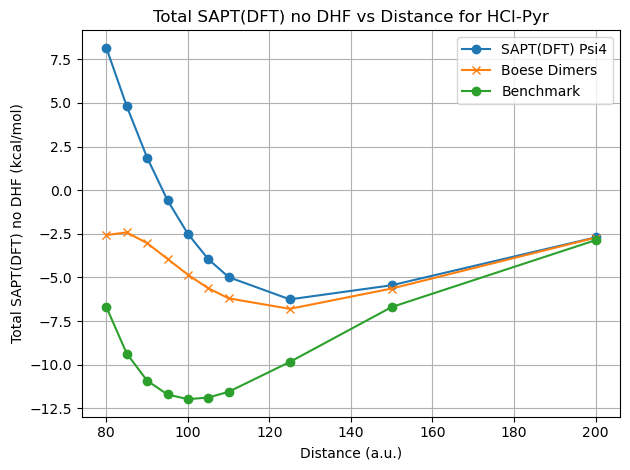

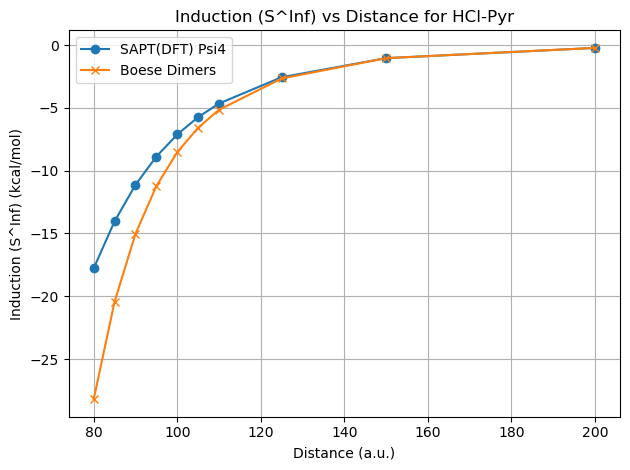

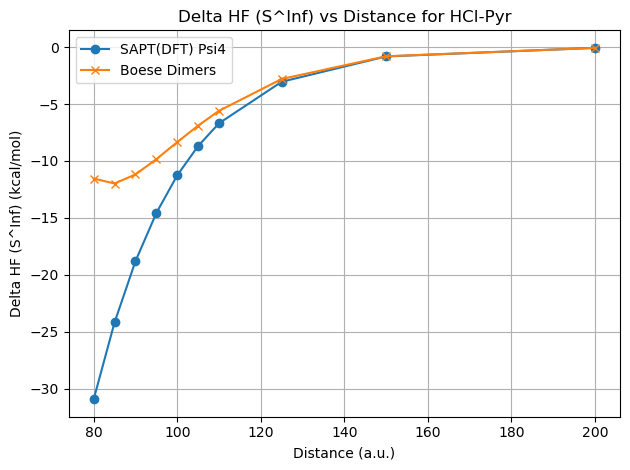

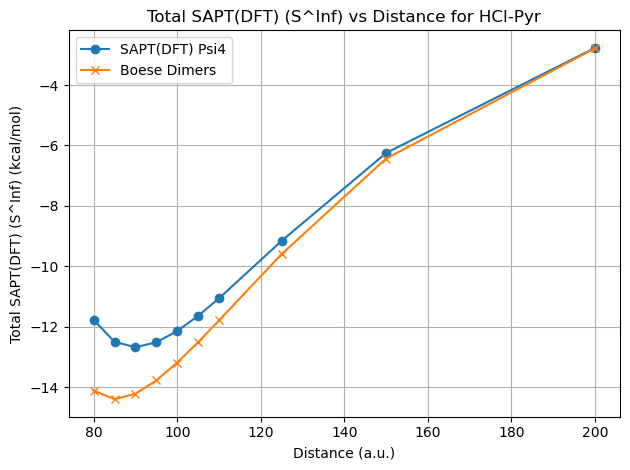

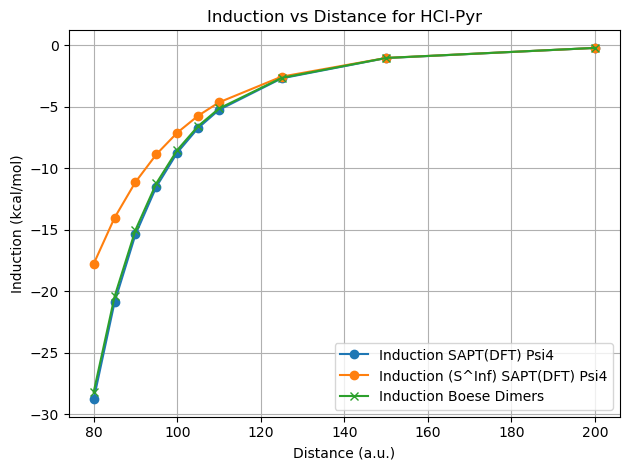

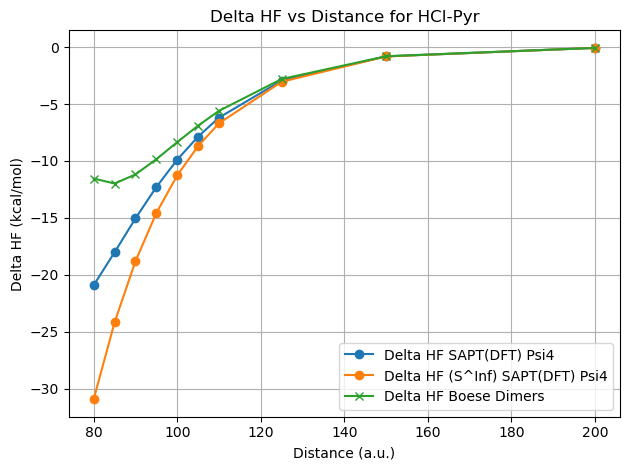

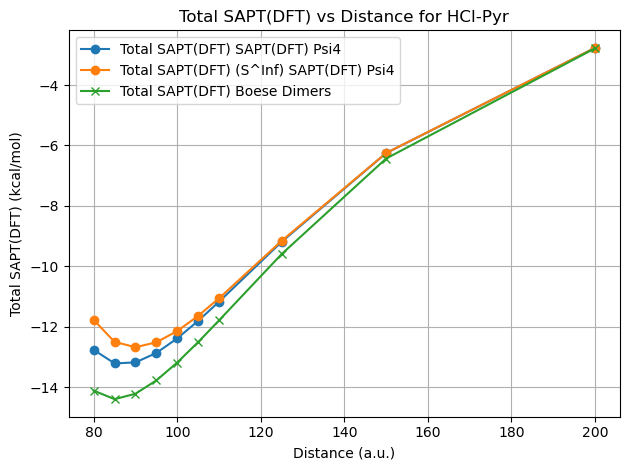

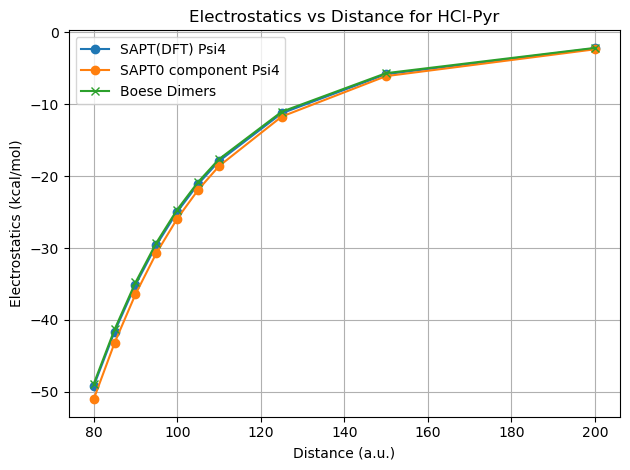

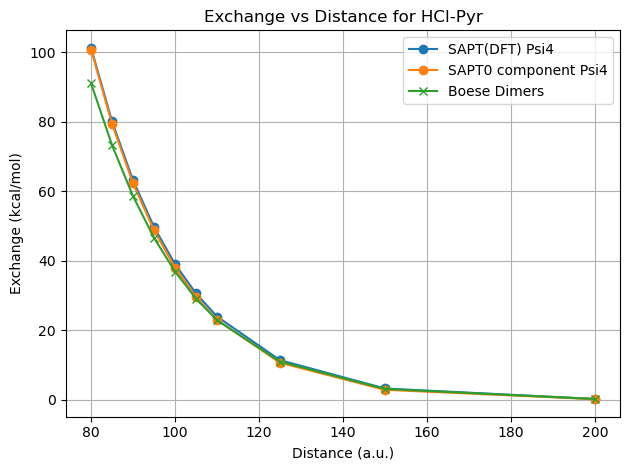

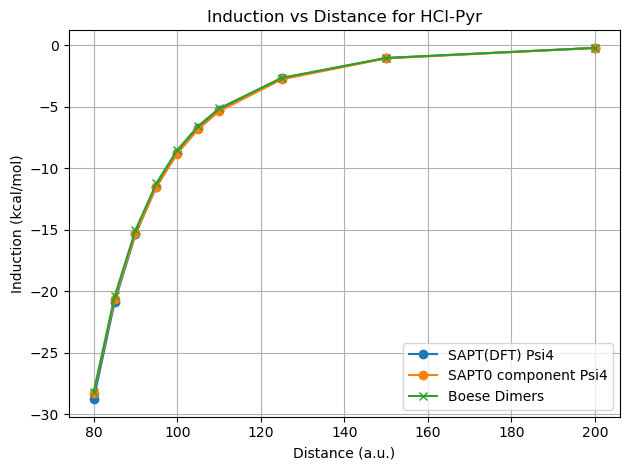

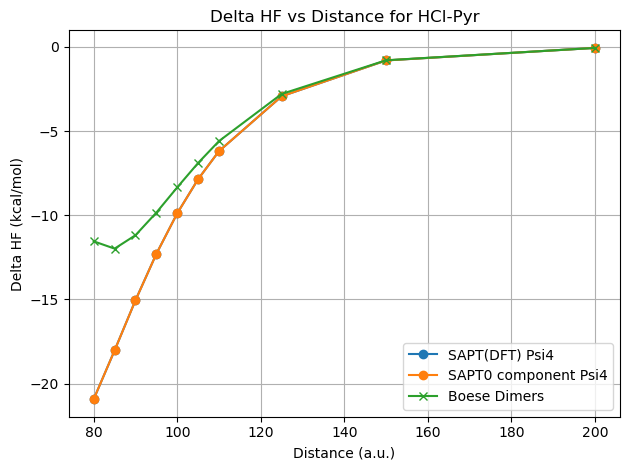

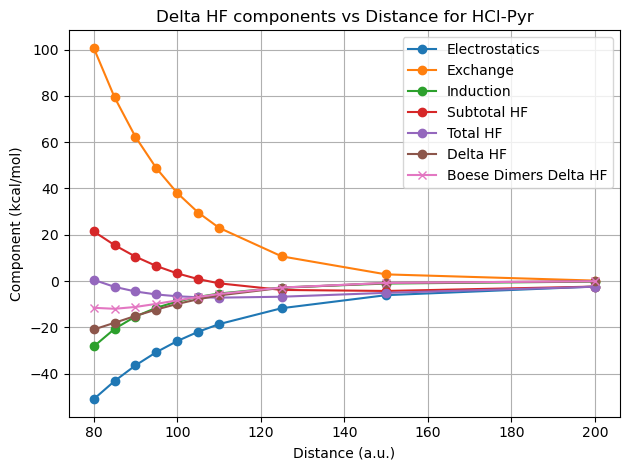

Filtered Boese dimers saved to /home/evanich/boese_dimers_calc/boese_dimers_filtered_1.28.csv
My dimers saved to /home/evanich/boese_dimers_calc/my_dimers_1.28.csv
DHF components from My dimers saved to dhf_my_dimers_1.28.csv
Benchmark saved to /home/evanich/boese_dimers_calc/benchmark_1.28.csv
SAPT0 Exch-Ind(S^2) = 0    39.907875
1    30.687474
2    23.454777
3    17.833734
4    13.501841
5    10.186308
6     7.663849
7     3.229606
8     0.755939
9     0.042221
Name: SAPT0 Exch-Ind(S^2), dtype: float64
SAPT0 Exch-Ind(S^Inf) = 0    51.420609
1    37.815395
2    27.840620
3    20.517325
4    15.135972
5    11.177130
6     8.262425
7     3.359354
8     0.765726
9     0.042273
Name: SAPT0 Exch-Ind(S^Inf), dtype: float64
Delta HF (S^2) = 0   -22.192214
1   -19.165705
2   -16.032424
3   -13.118169
4   -10.564732
5    -8.408958
6    -6.634382
7    -3.148227
8    -0.859207
9    -0.061755
Name: Delta HF, dtype: float64
Delta HF (S^Inf) = 0   -33.704949
1   -26.293626
2   -20.418266
3   -15.80

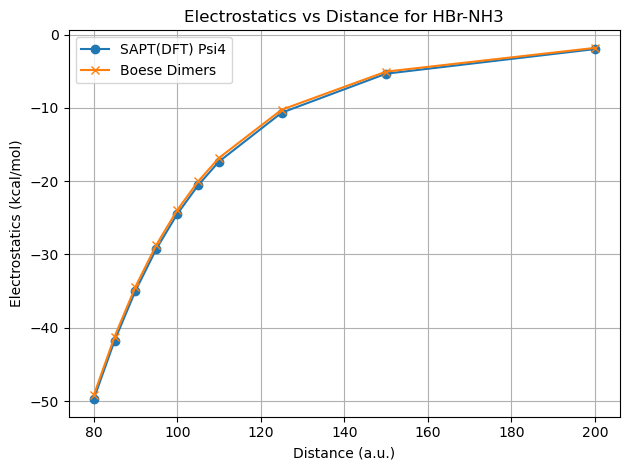

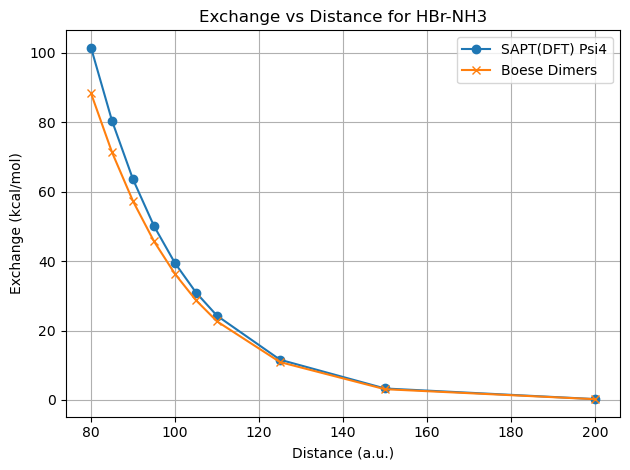

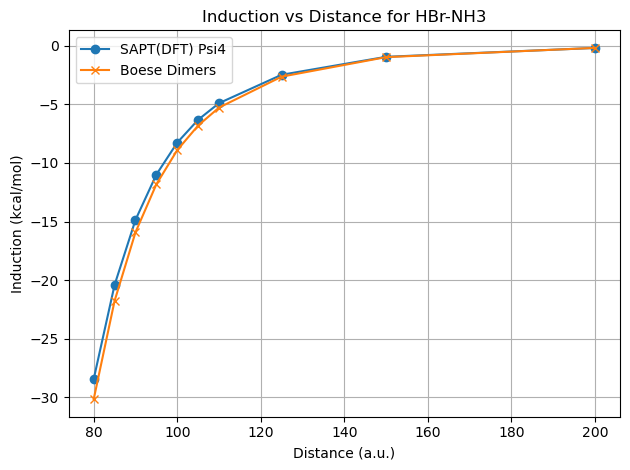

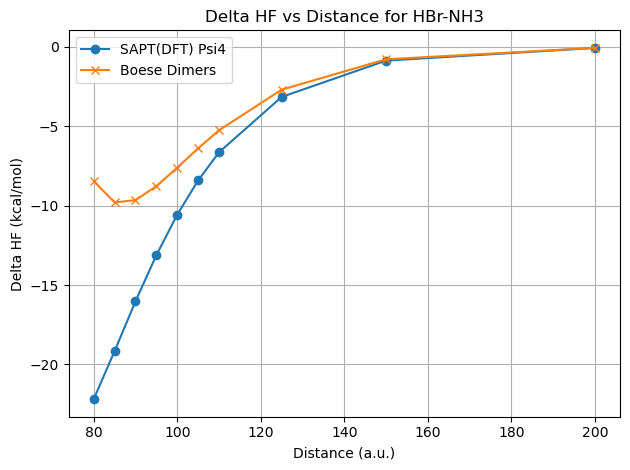

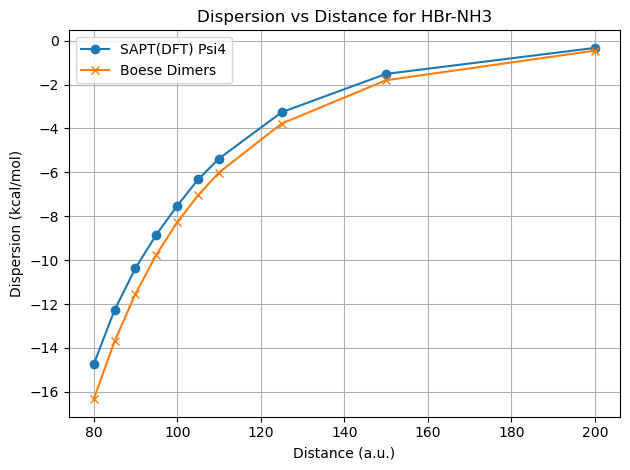

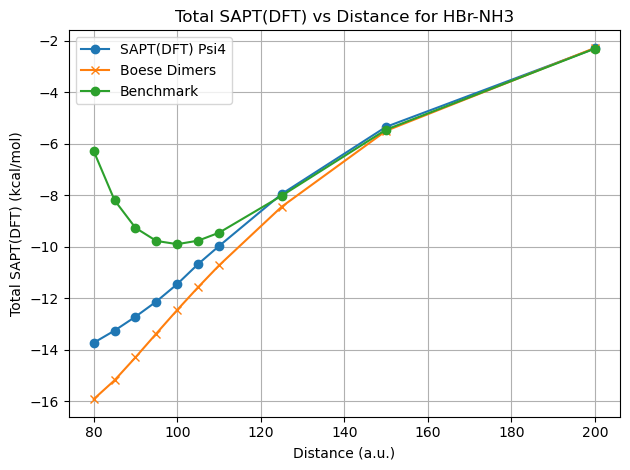

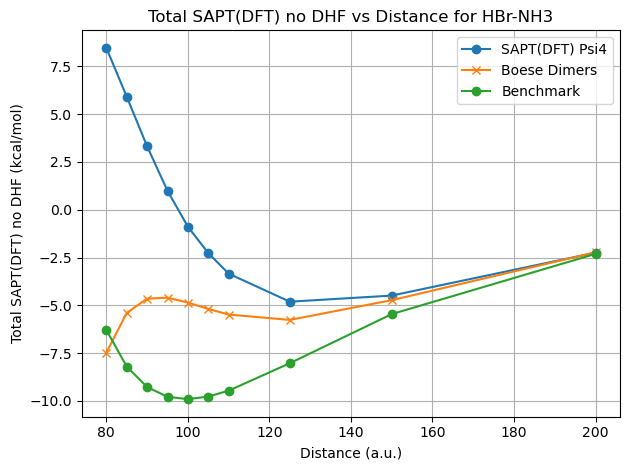

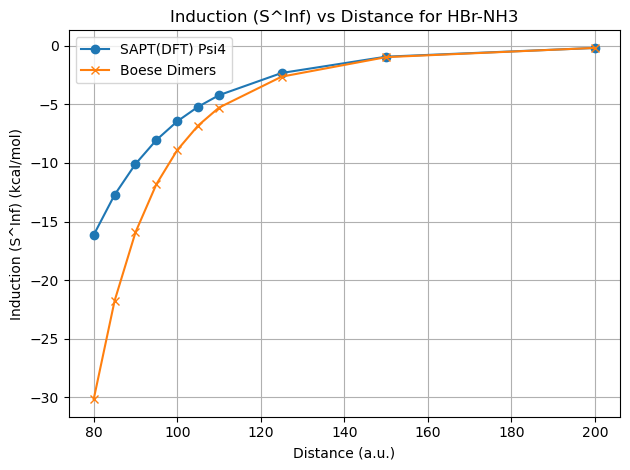

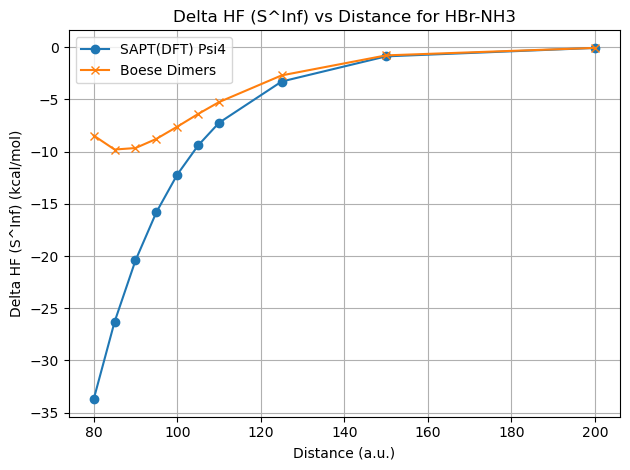

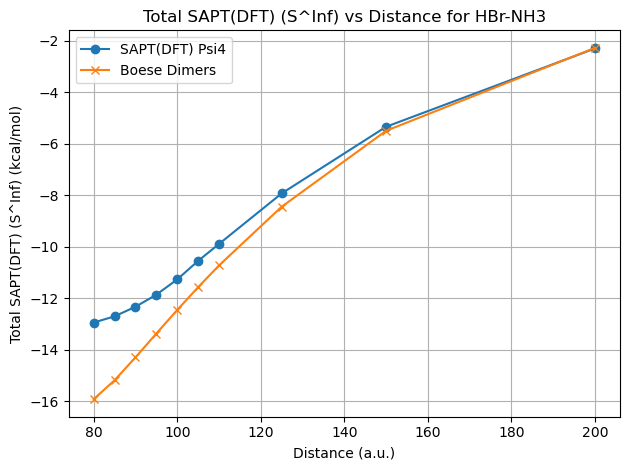

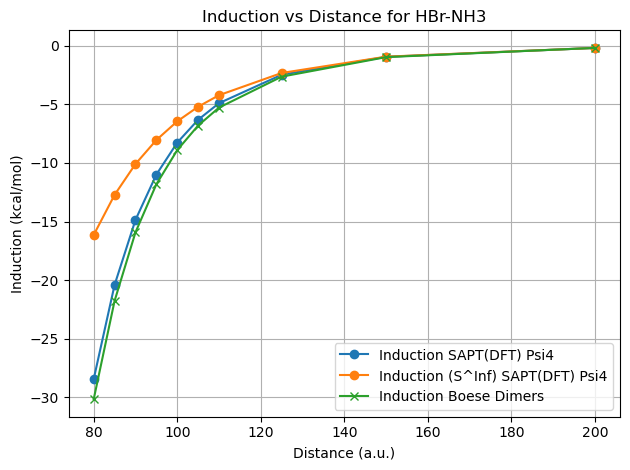

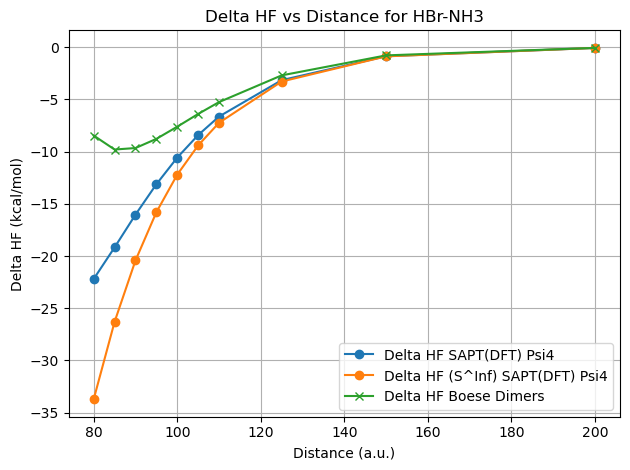

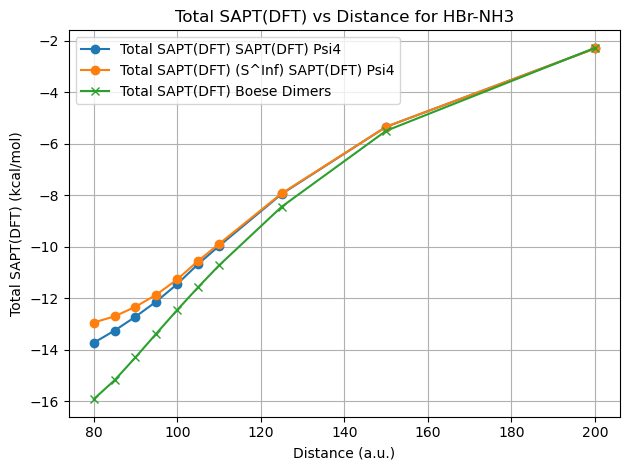

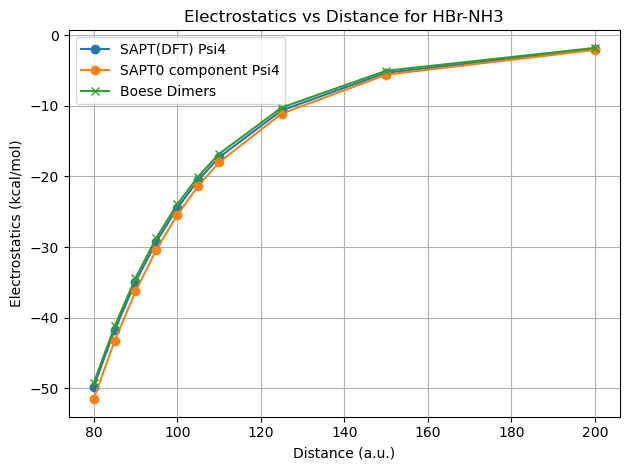

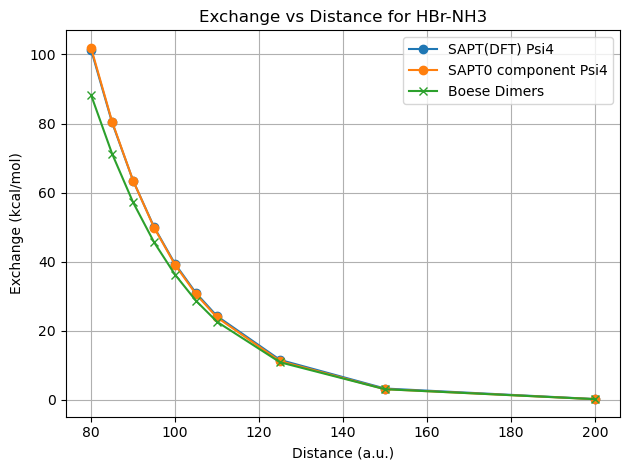

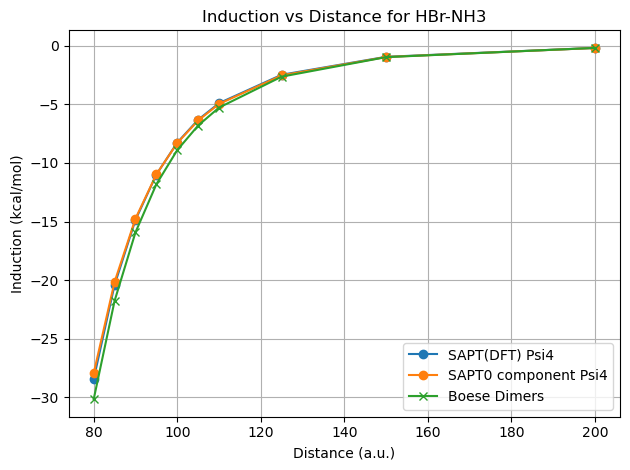

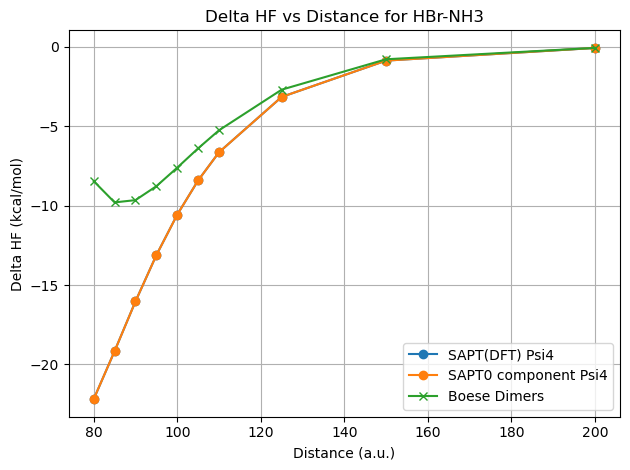

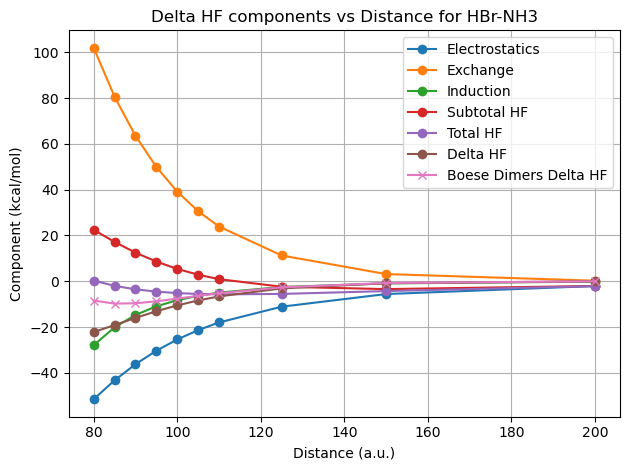

Filtered Boese dimers saved to /home/evanich/boese_dimers_calc/boese_dimers_filtered_1.32.csv
My dimers saved to /home/evanich/boese_dimers_calc/my_dimers_1.32.csv
DHF components from My dimers saved to dhf_my_dimers_1.32.csv
Benchmark saved to /home/evanich/boese_dimers_calc/benchmark_1.32.csv
SAPT0 Exch-Ind(S^2) = 0    34.213757
1    26.700065
2    20.660808
3    15.868869
4    12.109036
5     9.189118
6     6.940813
7     2.932198
8     0.676737
9     0.036760
Name: SAPT0 Exch-Ind(S^2), dtype: float64
SAPT0 Exch-Ind(S^Inf) = 0    49.138904
1    36.131478
2    26.577521
3    19.556453
4    14.393534
5    10.596895
6     7.804173
7     3.126810
8     0.692187
9     0.036850
Name: SAPT0 Exch-Ind(S^Inf), dtype: float64
Delta HF (S^2) = 0   -29.001284
1   -25.041895
2   -20.992349
3   -17.235512
4   -13.938244
5   -11.145731
6    -8.836805
7    -4.258147
8    -1.191314
9    -0.088766
Name: Delta HF, dtype: float64
Delta HF (S^Inf) = 0   -43.926431
1   -34.473308
2   -26.909062
3   -20.92

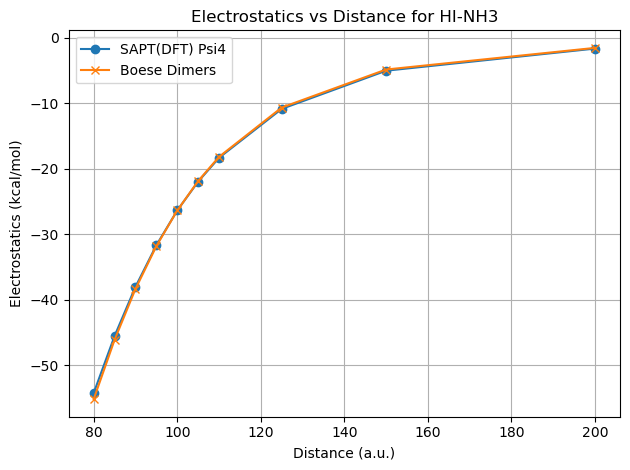

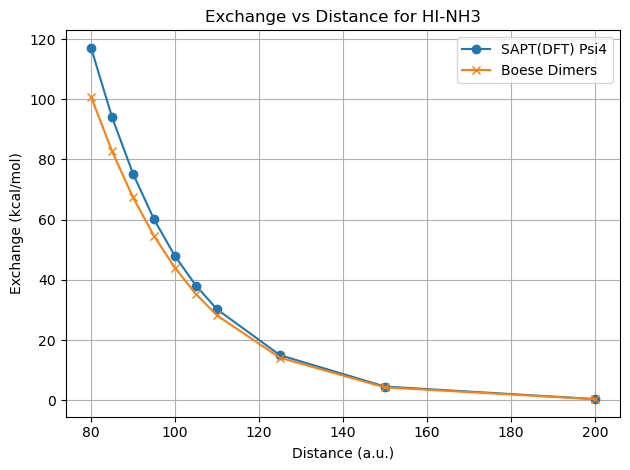

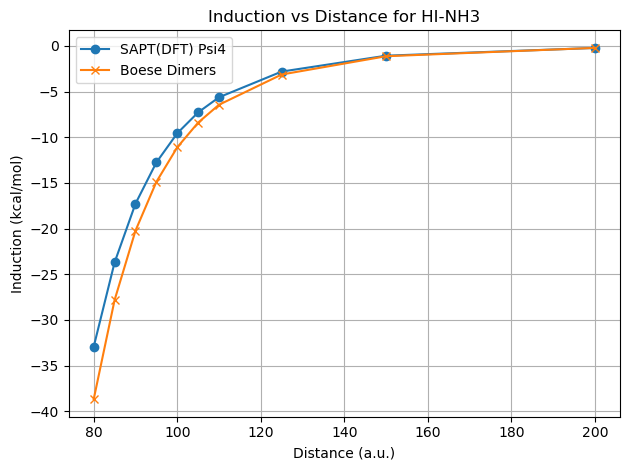

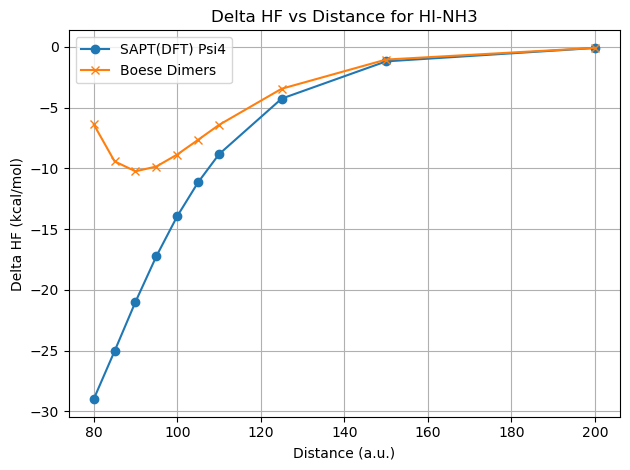

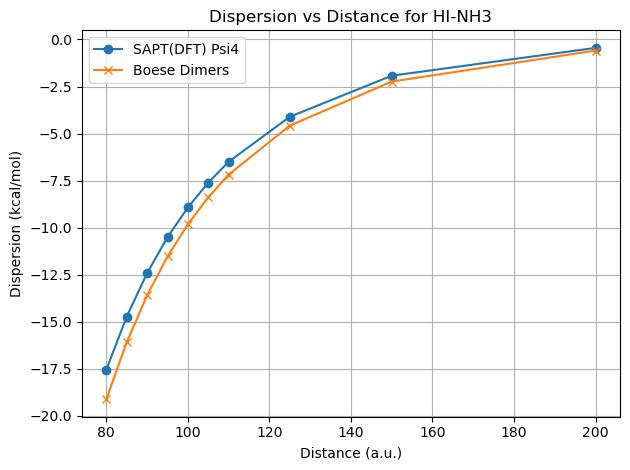

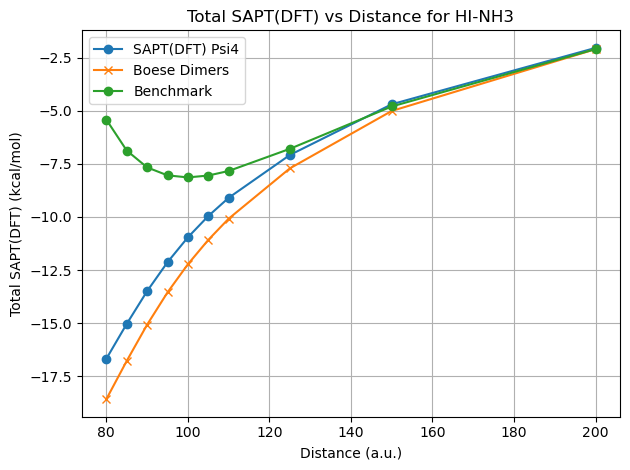

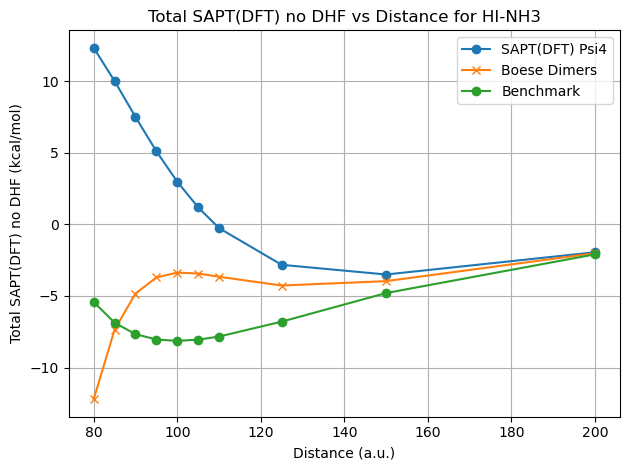

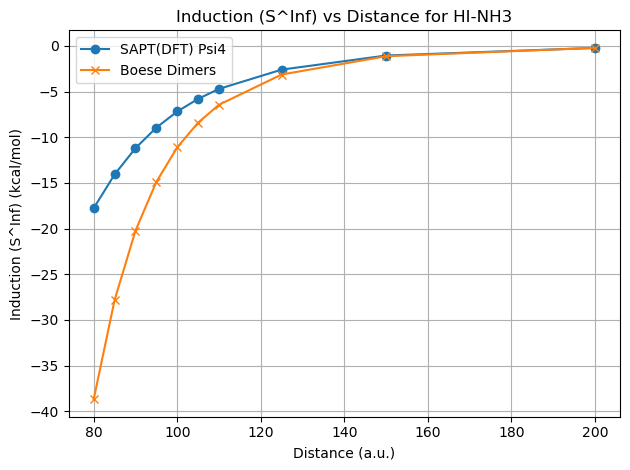

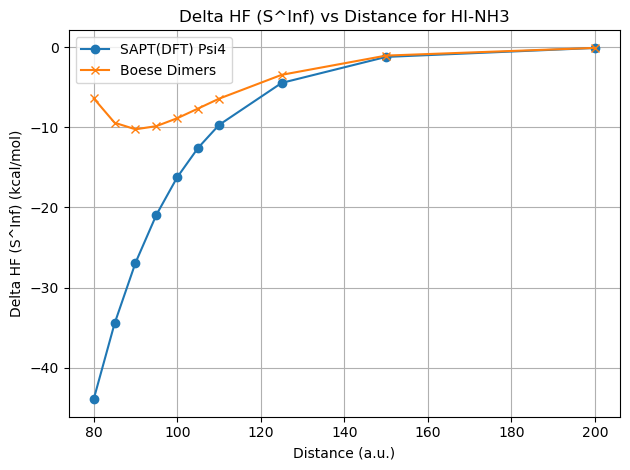

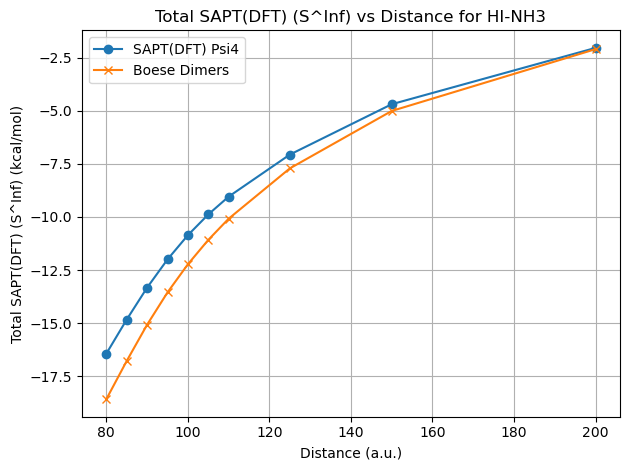

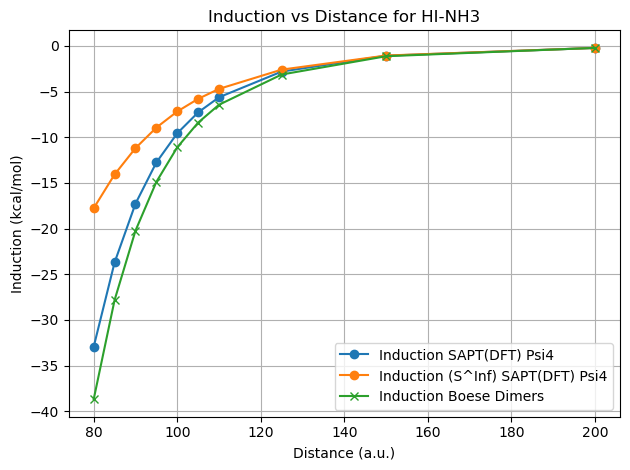

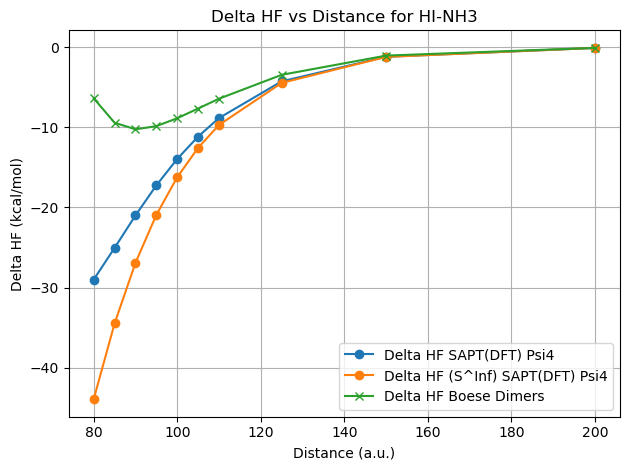

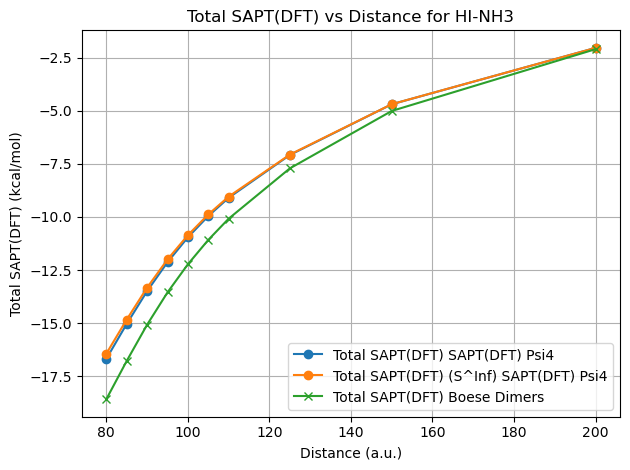

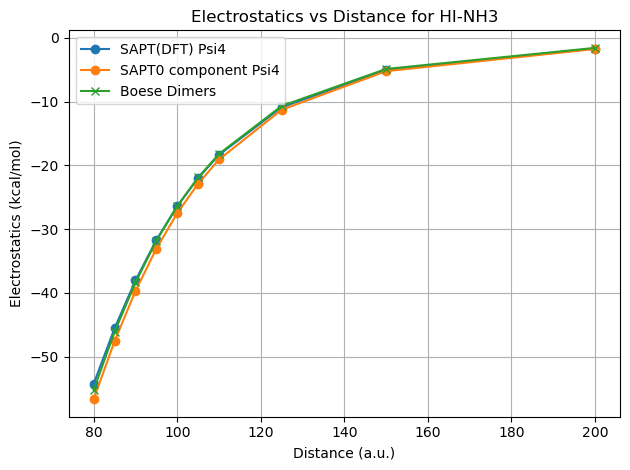

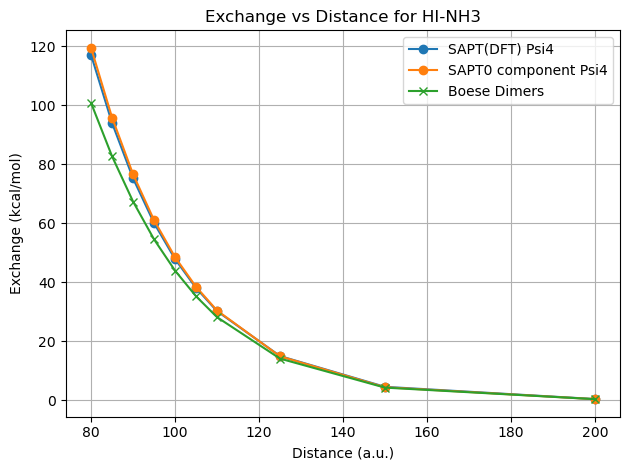

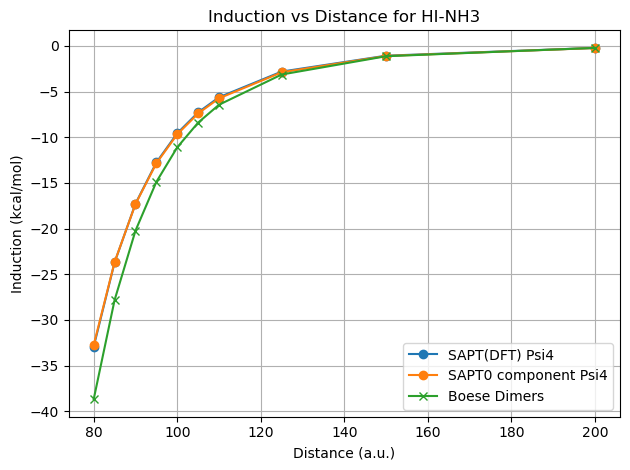

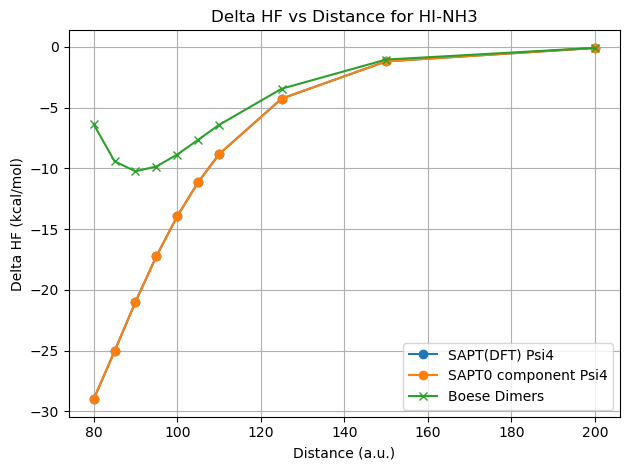

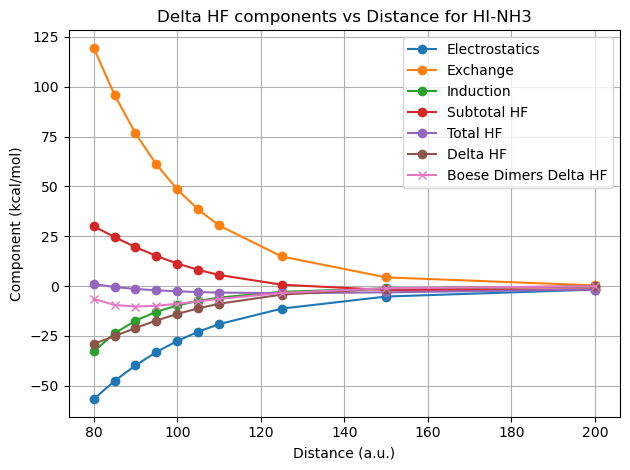

In [41]:
directory = '/home/evanich/boese_dimers_calc'
additional_file = '/home/evanich/NCIAtlas/tables/NCIA_HB300SPXx10/NCIA_HB300SPXx10_dft-sapt_pbe0.txt'
benchmark_file = '/home/evanich/NCIAtlas/tables/NCIA_HB300SPXx10/NCIA_HB300SPXx10_benchmark.txt'
#patterns = [r'1\.22.*\.out']
patterns = [r'1\.22.*\.out', r'1\.27.*\.out', r'1\.28.*\.out', r'1\.32.*\.out']
systems = {
    '1.22': 'HCl-NH3',
    '1.27': 'HCl-Pyr',
    '1.28': 'HBr-NH3',
    '1.32': 'HI-NH3'
}

boese_dimers = load_boese_dimers(additional_file)
benchmark = load_benchmark(benchmark_file)
#for system, system_name in systems.items():
#    my_dimers = collect_data(directory, [f'{system}.*\.out'])
#    boese_dimers_filtered = boese_dimers[boese_dimers['System'].str.startswith(system)]
#    plot_data(my_dimers, boese_dimers, system, system_name)
#    plot_boese_dimers(boese_dimers_filtered, system_name)
#    save_filtered_boese_dimers(boese_dimers_filtered, system)
#    plot_boese_dimers_from_file(f'boese_dimers_filtered_{system}.csv', system_name)

for system, system_name in systems.items():
    my_dimers = collect_data(directory, [f'{system}.*\.out'])
    my_dimers_dhf = collect_dhf_data(directory, [f'{system}.*\.out'])
    boese_dimers_filtered = boese_dimers[boese_dimers['System'].str.startswith(system)]
    benchmark_filtered = benchmark[benchmark['System'].str.startswith(system)]
    save_filtered_boese_dimers(boese_dimers_filtered, system)
    save_my_dimers(my_dimers, system)
    save_dhf_my_dimers(my_dimers_dhf, system)
    save_benchmark(benchmark_filtered, system)
    plot_data(system, system_name)
    plot_data_wcomponents(system, system_name)
    plot_dhf_data(system, system_name)


In [42]:
hcl_nh3 = f'my_dimers_1.22.csv'
hcl_nh3_df = pd.read_csv(hcl_nh3)
hcl_nh3_df


Electrostatics   Exchange  Induction  SAPT(DFT) Exch-Ind(S^Inf)  \
0      -41.911354  80.716053 -36.487664                  37.868474   
1      -35.033777  62.732520 -28.108089                  27.709370   
2      -29.272144  48.634245 -21.666172                  20.312103   
3      -24.498916  37.625422 -16.724716                  14.918509   
4      -20.569638  29.055018 -12.936904                  10.976511   
5      -17.345085  22.398745 -10.032045                   8.087955   
6      -14.701656  17.240966  -7.802293                   5.967439   
7       -9.277819   7.795689  -3.745134                   2.410590   
8       -4.882244   2.031763  -1.189330                   0.545458   
9       -1.927889   0.130008  -0.167298                   0.029438   

   SAPT(DFT) Exch-Ind(S^2)   Delta HF  SAPT0 Exch-Ind(S^Inf)  \
0                31.040159 -16.635434              33.845879   
1                23.589928 -13.800432              24.583029   
2                17.839237 -11.166854              17.892081   
3                13.440013  -8.879276              13.048113   
4                10.095565  -6.971692               9.533540   
5                 7.564642  -5.423238               6.978130   
6                 5.657390  -4.189565               5.116340   
7                 2.346979  -1.881306               2.035091   
8                 0.541021  -0.476383               0.448336   
9                 0.029418  -0.030805               0.022697   

   SAPT0 Exch-Ind(S^2)  Dispersion  Total SAPT(DFT)  Distance  
0            27.565118  -11.906770        -9.589734        80  
1            20.835251   -9.904503       -10.313849        85  
2            15.667696   -8.273279       -10.577350        90  
3            11.733865   -6.936734       -10.534943        95  
4             8.760013   -5.834287       -10.285810       100  
5             6.524326   -4.919994        -9.898379       105  
6             4.850833   -4.163570        -9.426554       110  
7             1.982568   -2.534736        -7.761999       125  
8             0.444899   -1.141341        -5.181153       150  
9             0.022683   -0.254088        -2.219267       200

In [43]:
boese_dimers_filtered_hcl_nh3 = f'boese_dimers_filtered_1.22.csv'
boese_dimers_filtered_hcl_nh3_df = pd.read_csv(boese_dimers_filtered_hcl_nh3)
boese_dimers_filtered_hcl_nh3_df
#boese_dimers_hcl_nh3_sum = boese_dimers_filtered_hcl_nh3_df['Electrostatics'] + boese_dimers_filtered_hcl_nh3_df['Exchange'] + boese_dimers_filtered_hcl_nh3_df['Induction'] + boese_dimers_filtered_hcl_nh3_df['Delta HF'] + boese_dimers_filtered_hcl_nh3_df['Dispersion']
#boese_dimers_hcl_nh3_sum

System  Electrostatics  Exchange  Induction  Delta HF  Dispersion  \
0  1.22_080         -41.419    73.562    -19.289   -10.382     -12.992   
1  1.22_085         -34.536    57.979    -13.872    -9.896     -10.824   
2  1.22_090         -28.783    45.438    -10.168    -8.750      -9.057   
3  1.22_095         -24.028    35.439     -7.597    -7.395      -7.609   
4  1.22_100         -20.123    27.528     -5.782    -6.067      -6.413   
5  1.22_105         -16.926    21.307     -4.474    -4.875      -5.420   
6  1.22_110         -14.313    16.442     -3.513    -3.860      -4.592   
7  1.22_125          -8.976     7.447     -1.820    -1.813      -2.827   
8  1.22_150          -4.676     1.920     -0.695    -0.473      -1.298   
9  1.22_200          -1.806     0.118     -0.134    -0.032      -0.306   

   Total SAPT(DFT)  Distance  
0          -10.520      80.0  
1          -11.148      85.0  
2          -11.321      90.0  
3          -11.190      95.0  
4          -10.856     100.0  
5          -10.389     105.0  
6           -9.836     110.0  
7           -7.988     125.0  
8           -5.221     150.0  
9           -2.160     200.0

Filtered Boese dimers saved to /home/evanich/boese_dimers_calc/boese_dimers_filtered_1.22.csv
My dimers saved to /home/evanich/boese_dimers_calc/aug_cc_pvqz_calc/my_dimers_au_cc_pvqz_1.22.csv
DHF components from My dimers saved to /home/evanich/boese_dimers_calc/aug_cc_pvqz_calc/dhf_my_dimers_aug_cc_pvqz_1.22.csv
SAPT0 Exch-Ind(S^2) = 0    27.565118
1    20.835251
2    15.667696
3    11.733865
4     8.760013
5     6.524326
6     4.850833
7     1.982568
8     0.444899
9     0.022683
Name: SAPT0 Exch-Ind(S^2), dtype: float64
SAPT0 Exch-Ind(S^Inf) = 0    33.845879
1    24.583029
2    17.892081
3    13.048113
4     9.533540
5     6.978130
6     5.116340
7     2.035091
8     0.448336
9     0.022697
Name: SAPT0 Exch-Ind(S^Inf), dtype: float64
Delta HF (S^2) = 0   -16.635434
1   -13.800432
2   -11.166854
3    -8.879276
4    -6.971692
5    -5.423238
6    -4.189565
7    -1.881306
8    -0.476383
9    -0.030805
Name: Delta HF, dtype: float64
Delta HF (S^Inf) = 0   -22.916195
1   -17.548210
2   -1

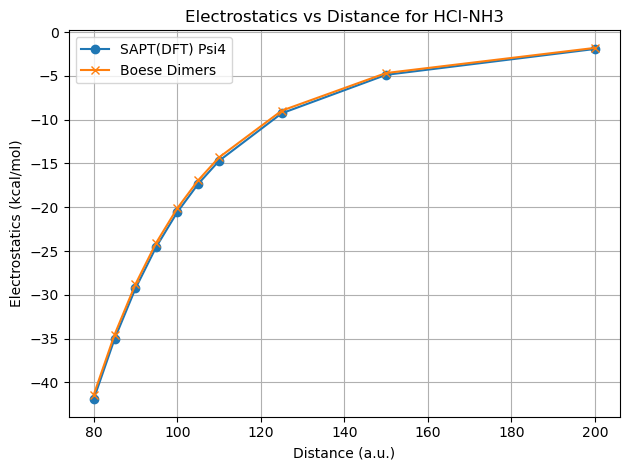

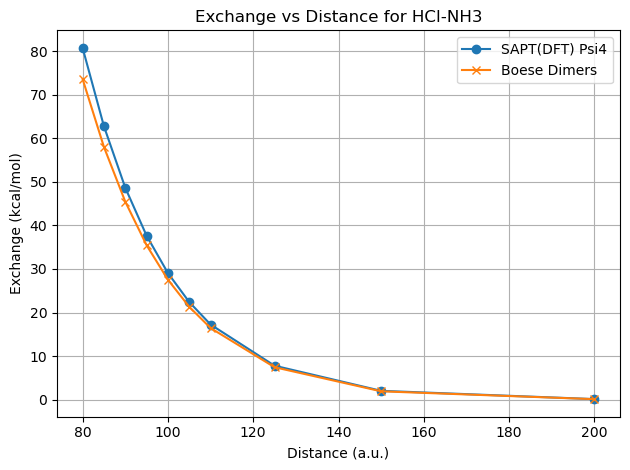

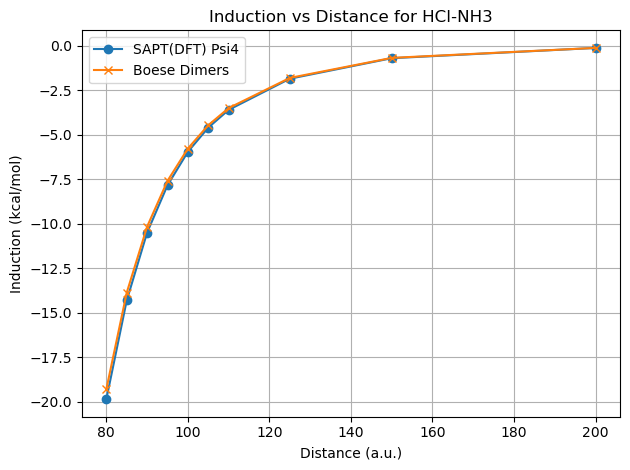

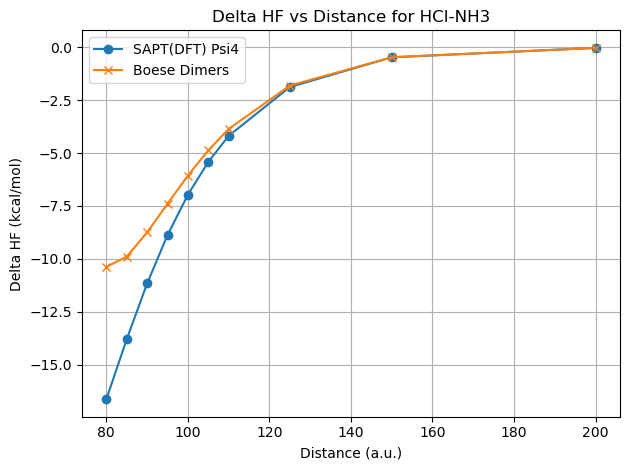

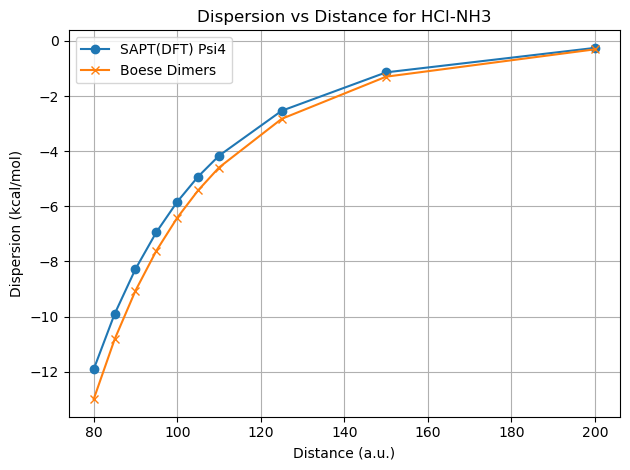

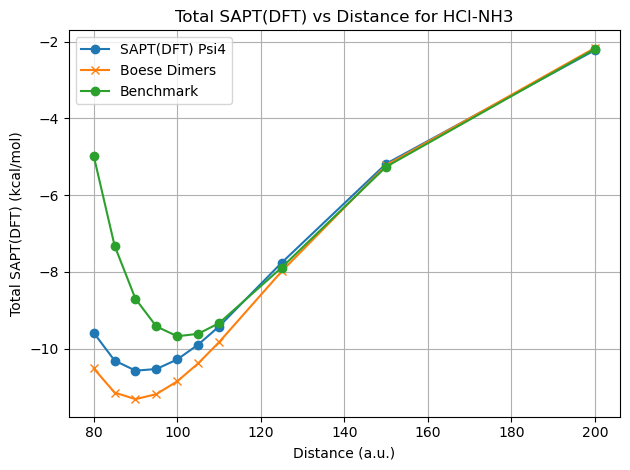

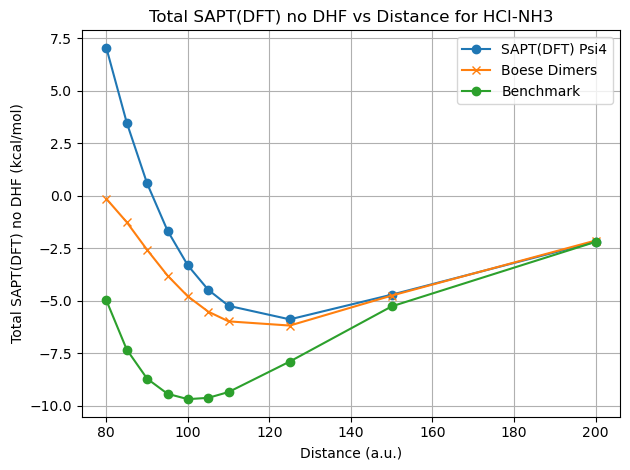

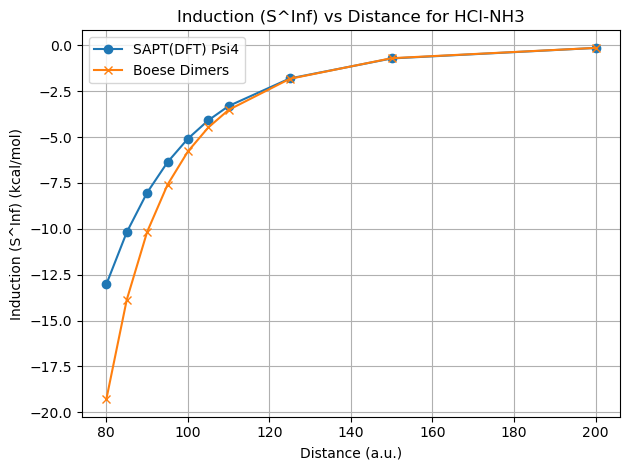

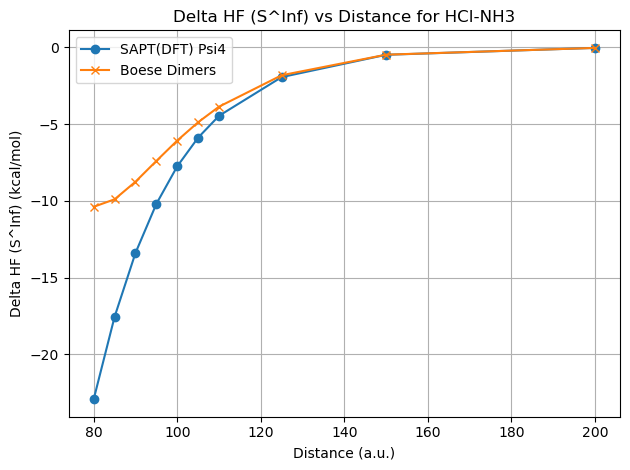

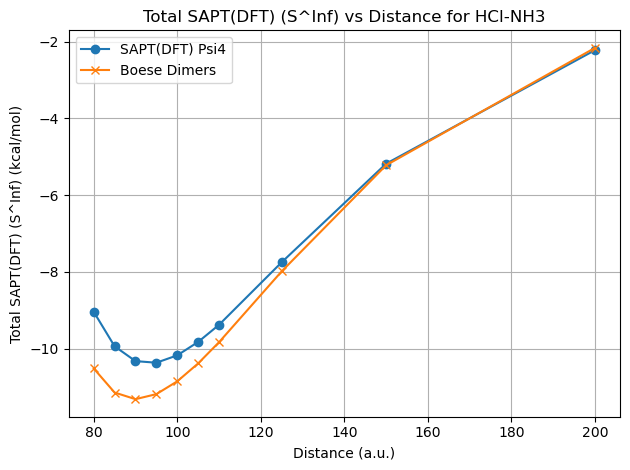

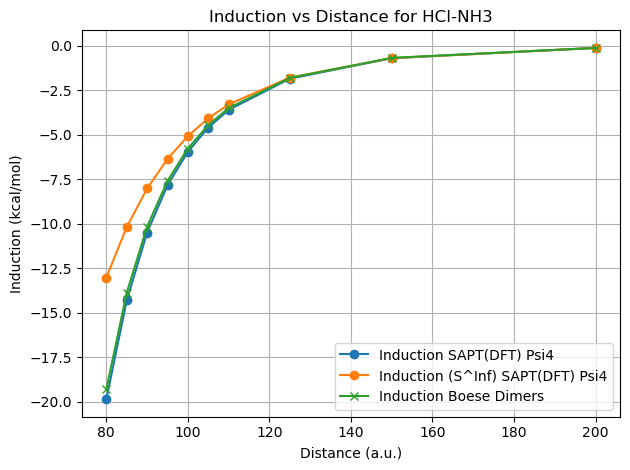

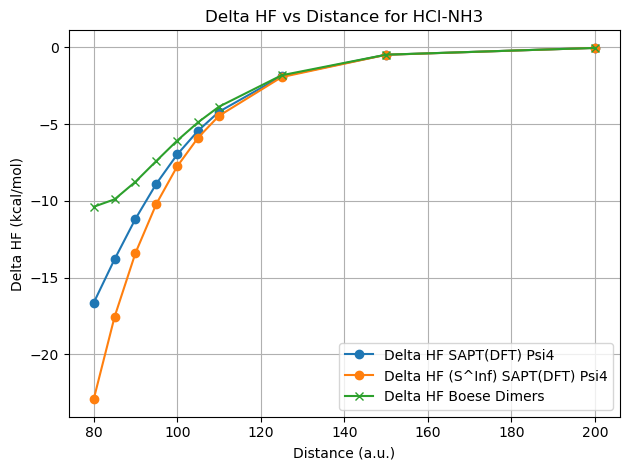

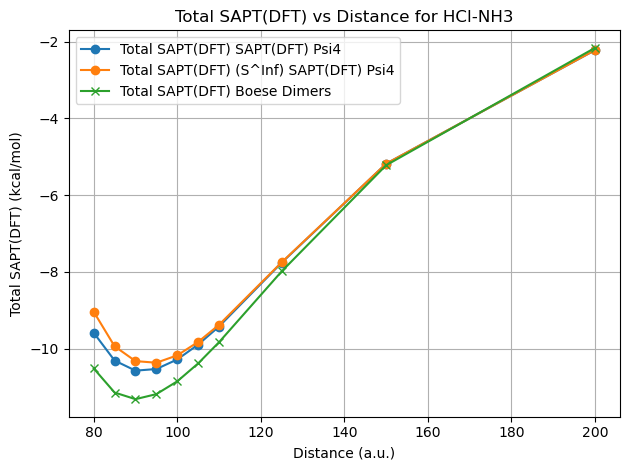

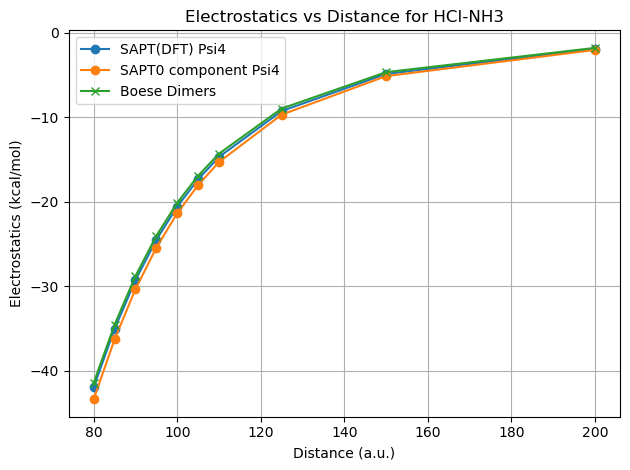

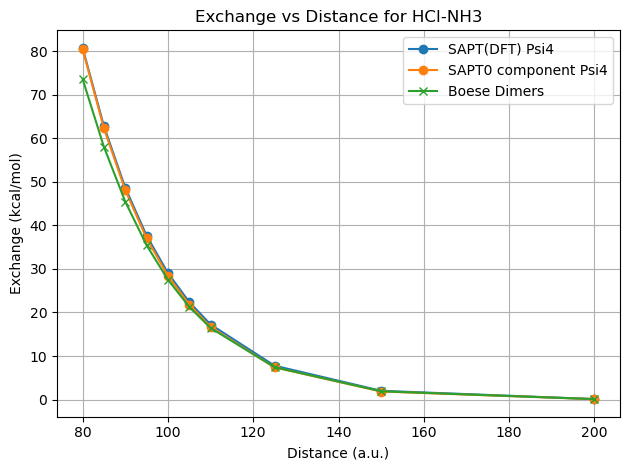

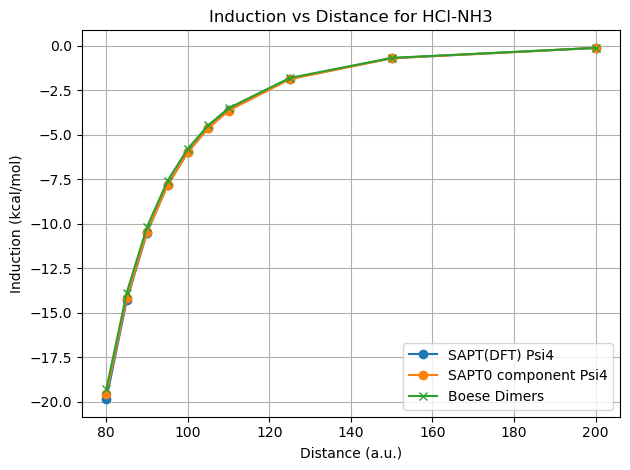

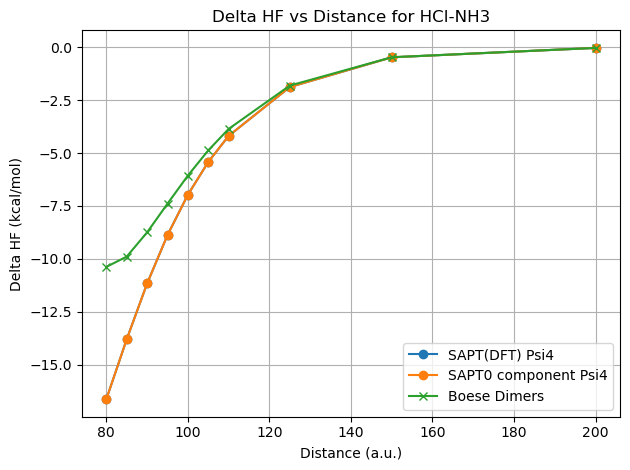

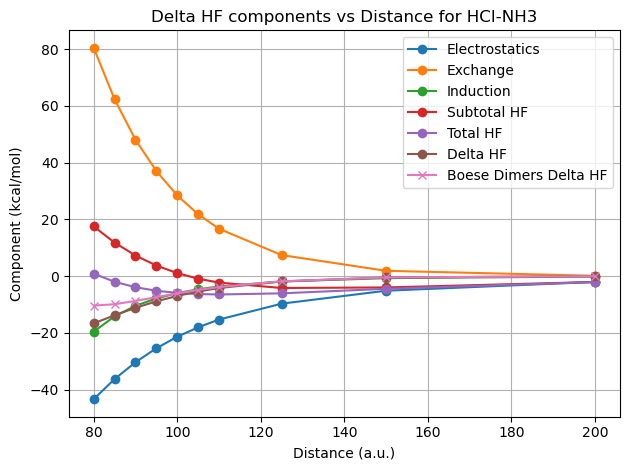

In [44]:
directory2 = '/home/evanich/boese_dimers_calc/aug_cc_pvqz_calc'
additional_file = '/home/evanich/NCIAtlas/tables/NCIA_HB300SPXx10/NCIA_HB300SPXx10_dft-sapt_pbe0.txt'
#patterns = [r'1\.22.*\.out']
patterns = [r'1\.22.*\.out']
systems = {
    '1.22': 'HCl-NH3',
}

boese_dimers = load_boese_dimers(additional_file)

#for system, system_name in systems.items():
#    my_dimers = collect_data(directory, [f'{system}.*\.out'])
#    boese_dimers_filtered = boese_dimers[boese_dimers['System'].str.startswith(system)]
#    plot_data(my_dimers, boese_dimers, system, system_name)
#    plot_boese_dimers(boese_dimers_filtered, system_name)
#    save_filtered_boese_dimers(boese_dimers_filtered, system)
#    plot_boese_dimers_from_file(f'boese_dimers_filtered_{system}.csv', system_name)

for system, system_name in systems.items():

    my_dimers2 = collect_data(directory2, [f'aug_cc_pvqz_calc/{system}.*\.out'])
    my_dimers_dhf = collect_dhf_data(directory, [f'aug_cc_pvqz_calc/{system}.*\.out'])
    boese_dimers_filtered = boese_dimers[boese_dimers['System'].str.startswith(system)]
    save_filtered_boese_dimers(boese_dimers_filtered, system)
    save_my_dimers2(my_dimers2, system)
    save_dhf_my_dimers2(my_dimers_dhf, system)
    plot_data(system, system_name)
    plot_data_wcomponents(system, system_name)
    plot_dhf_data(system, system_name)